# stability gpt 5.1 thinking

## base

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

# ---------------------------------------------------------
# base prompts (as originally given)
# ---------------------------------------------------------
base_prompts: List[str] = [
    "Show the distribution of end schedule deviation for operations labeled 'mit TA'.",
    "Display the distribution of cycle time deviation for sawing operations with completion in 2024.",
    "Show me a statistical summary of the cycle times for ressource group Drahtschneiden.",
    "Display key statistics of cycles times for finished operations.",
    "What are average cycle times by ressource group for finished parts?",
    "Compare the max lead times for Fräsen Gruppe Kleinteile by operation type.",
    "Over time, how is monthly start schedule deviation developing for function check operations?",
    "Show me the trend for weekly end schedule deviations of operations in 2025.",
    "How is TA Zugang correlating to TA Abgang for Fräsen DM100 operations?",
    "Show me how the numerical values in the data are related to each other, finished operations only.",
    "What are the main drivers for end-dates being higher or lower? Only operations in 2024.",
    "Which drivers affected lead times for assembly operations?",
    "Forecast weekly average end-date deviation for the next 6 weeks.",
    "Show me how the maximum start deviation will change for the next 6 weeks.",
    "What is the expected end-date deviation for a new case given start delay of 10 days and run-through time of 3 days.",
    "If start deviation is 3 days and cycle time is 2 days, what would be a good prediction for the end deviation?",
    "Predict the lead time deviation if lead time is 3 days and start deviation is -20 days.",
    "Classify the likely ta_status if start is 10 days early and resource group ‘Fräsen DM100’.",
    "Which ta status is to expect for a operation type 'Kleinbauteile schlichten' with a cycle time of 1?",
    "Classify a likely ta status in a situation where the operation startet 20 days early with a 'Funktionsprüfung'.",
    "How is the cycle time distributed for Profilschleifen across ta status categories?",
    "For Konstruktion operations, what are the main statistics about the end schedule deviation?",
    "Which resource groups drive the end-date deviation the most?",
    "Forecast the next 16 weeks of weekly average Lead-time deviation.",
    "Which resource group should we route to to minimize end deviation?",
    "Which operation type would be best for low cycle times?",
    "I want to improve cycle time (lower is better). What can I do? Show me decision options.",
    "For unfinshed operations: I want to decrease start deviation. What do I need to work on?",
    "Could I improve average cycle time if I use '3D CAM' as a substitute for  ‘CAM-Fertigung’?",
    "What happens to expected end-date deviation if we route work to 'Fräsen Gruppe 5-Achs' instead of ‘Fräsen DM100’?",
]

# ---------------------------------------------------------
# Config object
# ---------------------------------------------------------
@dataclass
class AnalysisConfig:
    id: int
    base_prompt: str
    prompt: str
    family: str
    type: str
    filters: List[str]
    columns: List[str]
    prepare_actions: List[str]
    aggregate: List[str]

# ---------------------------------------------------------
# All configs for the 30 prompts (base)
# ---------------------------------------------------------
base_configs: List[AnalysisConfig] = [
    AnalysisConfig(
        id=1,
        base_prompt=base_prompts[0],
        prompt='''Take the operations DataFrame and restrict the data to rows where ta_status equals "mit TA".
Visualize the empirical distribution of ta_abgang (end schedule deviation in days) with a histogram.
Use matplotlib with a single row of subplots (nrows=1) and a total figure height of 5
(e.g. figsize=(12, 5)). Make sure axes are labeled in days and provide an informative title and x-/y-labels.''',
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(ta_status, 'mit TA')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang', 'ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=2,
        base_prompt=base_prompts[1],
        prompt='''Subset the dataset to sawing-related operations that have a completion date (ist_ende)
within calendar year 2024. Use ta_rel as cycle time deviation. Plot this deviation measure
as a histogram. Place any plots in a single row of axes and use a figure height of 5.''',
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(avg_type, 'Sägen')",
            "notna(ist_ende)",
            "dt.year(ist_ende)==2024",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "avg_type",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=3,
        base_prompt=base_prompts[2],
        prompt='''Filter the operations table to resource_group == "Drahtschneiden".
On this subset, generate a descriptive statistics table for ist_dlz (cycle time in days),
including count, mean, standard deviation, minimum, 25%, 50%, 75%, and maximum.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(resource_group, 'Drahtschneiden')",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=4,
        base_prompt=base_prompts[3],
        prompt='''Limit the data to operations that are finished (status == "finished" and ist_ende
not null). For this population, compute key descriptive statistics of ist_dlz (cycle time),
such as count, mean, standard deviation, min, quartiles, and max.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "status",
            "resource_group",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=5,
        base_prompt=base_prompts[4],
        prompt='''Work with finished parts only (status == "finished" and valid ist_ende).
Group the data by resource_group and calculate the mean ist_dlz (cycle time) per group.
Plot a bar chart of average cycle time versus resource_group, sorted by the mean ist_dlz.
Use a single-row matplotlib figure with a height of 5 for the bar display.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
            "notna(resource_group)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ist_dlz)",
            "sort_values(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=6,
        base_prompt=base_prompts[5],
        prompt='''Select all operations where resource_group equals "Fräsen Gruppe Kleinteile".
Use ist_dlz as lead time measure. Aggregate by avg_type (operation type) and calculate the
maximum lead time per operation type. Display these maxima in a bar chart ordered by the
largest max lead time, using a single-row, 5-unit-high figure.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(resource_group, 'Fräsen Gruppe Kleinteile')",
            "notna(ist_dlz)",
            "notna(avg_type)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).max(ist_dlz)",
            "sort_values(ist_dlz, ascending=False)",
        ],
    ),

    AnalysisConfig(
        id=7,
        base_prompt=base_prompts[6],
        prompt='''Isolate function check operations (avg_type == "Funktionsprüfung").
Use ist_start as the time dimension, and aggregate ta_zugang (start schedule deviation) by calendar
month. Compute the average monthly ta_zugang. Plot this monthly series
in a line chart, using a one-row matplotlib layout with figure height 5 and clear date tick labels.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('M').mean(ta_zugang)",
        ],
    ),

    AnalysisConfig(
        id=8,
        base_prompt=base_prompts[7],
        prompt='''Restrict the operations to those with ist_ende in the calendar year 2025.
Set ist_ende as the index, resample by week, and compute the mean ta_abgang (end schedule
deviation) for each week. Plot the resulting weekly series as a line chart in a single-row,
height-5 figure, showing how end deviations develop throughout 2025.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2025",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=9,
        base_prompt=base_prompts[8],
        prompt='''Filter the operations data to resource_group == "Fräsen DM100".
Within this subset, compute the statistical correlation between ta_zugang (start deviation) and
ta_abgang (end deviation). Additionally, create a scatter plot with ta_zugang on the x-axis and
ta_abgang on the y-axis in a 1-row, height-5 figure to visually inspect the relationship.''',
        family="diagnostic",
        type="correlation_scatter",
        filters=[
            "eq(resource_group, 'Fräsen DM100')",
            "notna(ta_zugang)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_zugang",
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang', 'ta_abgang'])",
        ],
        aggregate=[
            "corr(ta_zugang, ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=10,
        base_prompt=base_prompts[9],
        prompt='''Focus on rows with finished status (status == "finished").
Select a relevant set of numeric features: ist_dlz, ta_zugang, ta_abgang, and ta_rel.
Construct a correlation matrix over these numeric columns and visualize it as a heatmap in a
single-row, height-5 figure to summarize how the metrics relate for finished operations only.''',
        family="diagnostic",
        type="correlation_matrix",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'ta_zugang', 'ta_abgang', 'ta_rel'])",
        ],
        aggregate=[
            "corr(['ist_dlz','ta_zugang','ta_abgang','ta_rel'])",
        ],
    ),

    AnalysisConfig(
        id=11,
        base_prompt=base_prompts[10],
        prompt='''Take only operations with ist_ende in the year 2024. Use ta_abgang (end schedule deviation)
as the response variable and treat ist_dlz, ta_zugang, ta_rel, resource_group, avg_type, and status
as predictors. Fit a tree-based regression model and derive feature importance scores to
identify which drivers influence ta_abgang most. Summarize the main drivers and plot
feature importances as a bar chart in a 1-row, 5-high figure.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2024",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ta_rel",
            "ist_dlz",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "dropna(['ta_abgang','ist_dlz','ta_zugang','ta_rel','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ist_dlz,ta_zugang,ta_rel,resource_group,avg_type,status], y=ta_abgang)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=12,
        base_prompt=base_prompts[11],
        prompt='''Filter to assembly-type operations (avg_type marks assembly).
Use ta_rel (lead-time deviation) as the target. Include predictors such as resource_group,
avg_type, status, ta_zugang, and ta_abgang. Fit a model and compute feature importance scores
to understand which drivers are most influential for assembly lead times. Display feature
importances in a one-row, height-5 bar plot.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "eq(avg_type, 'Montage')",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ta_zugang",
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ta_zugang','ta_abgang','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ta_zugang,ta_abgang,resource_group,avg_type,status], y=ta_rel)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=13,
        base_prompt=base_prompts[12],
        prompt='''Construct a univariate time series of weekly mean ta_abgang (end schedule deviation).
Use ist_ende as the time index, resample to weekly frequency, and compute the average ta_abgang per
week. Fit a time-series forecasting model on this weekly series and generate predictions
for the next 6 weeks. Plot both the historical data and the 6-week forecast in a single-row,
height-5 line chart, marking the forecast horizon clearly.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
            "fit(ARIMA, y=ta_abgang_weekly)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    AnalysisConfig(
        id=14,
        base_prompt=base_prompts[13],
        prompt='''Create a time series of weekly maximum ta_zugang (start deviation).
Use ist_start as the date axis, resample to weekly frequency, and compute the weekly maximum
ta_zugang. Train a time-series model on this weekly-max series and forecast the next 6 weeks of
maximum start deviation. Plot the historical and predicted weekly maxima in a single-row,
5-unit-high line figure.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('W').max(ta_zugang)",
            "fit(ARIMA, y=ta_zugang_weekly_max)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    AnalysisConfig(
        id=15,
        base_prompt=base_prompts[14],
        prompt='''Fit a supervised regression model with ta_abgang (end schedule deviation) as the target
and the inputs ta_zugang (start deviation) plus ist_dlz (run-through / cycle time).
Train on all records where these three fields are observed. Then, for a hypothetical operation
with ta_zugang = 10 days and ist_dlz = 3 days, generate a point prediction for ta_abgang.
Return the numerical prediction.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=10,ist_dlz=3])",
        ],
    ),

    AnalysisConfig(
        id=16,
        base_prompt=base_prompts[15],
        prompt='''Use the same or a similar regression model where ta_abgang is the target and
ta_zugang plus ist_dlz are predictors. After training on historical observations with non-missing
values, predict the end schedule deviation for a case with ta_zugang = 3 days and ist_dlz = 2 days.
Output the predicted ta_abgang.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=3,ist_dlz=2])",
        ],
    ),

    AnalysisConfig(
        id=17,
        base_prompt=base_prompts[16],
        prompt='''Set up a regression task with ta_rel (lead-time deviation) as the response and
ist_dlz (actual lead time) plus ta_zugang (start deviation) as predictors. Train on all observations
with non-null ta_rel, ist_dlz, and ta_zugang. Then, for a scenario with ist_dlz = 3 days and
ta_zugang = -20 days (start 20 days early), compute the predicted ta_rel. Provide the numeric
estimate.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_rel)",
            "notna(ist_dlz)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_rel",
            "ist_dlz",
            "ta_zugang",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ist_dlz','ta_zugang'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ist_dlz,ta_zugang], y=ta_rel)",
            "predict(LinearRegression, X=[ist_dlz=3,ta_zugang=-20])",
        ],
    ),

    AnalysisConfig(
        id=18,
        base_prompt=base_prompts[17],
        prompt='''Formulate a classification problem where ta_status is the label and features include
ta_zugang (start deviation) and resource_group. Use all rows with known ta_status to train a
classification model. Then, for a hypothetical operation with a 10-day early
start (ta_zugang = -10) and resource_group == "Fräsen DM100", compute class probabilities and
return the most likely ta_status.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(ta_zugang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','ta_zugang','resource_group'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[ta_zugang,resource_group], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[ta_zugang=-10,resource_group='Fräsen DM100'])",
        ],
    ),

    AnalysisConfig(
        id=19,
        base_prompt=base_prompts[18],
        prompt='''Train a classification model using ta_status as the target and avg_type
(operation type) and ist_dlz (cycle time) as predictors. Use all operations that have a defined
ta_status, avg_type, and ist_dlz. Then predict the most likely ta_status for a case with
avg_type == "Kleinbauteile schlichten" and ist_dlz = 1. Report the predicted label and
associated probabilities.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(avg_type)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_status",
            "avg_type",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','avg_type','ist_dlz'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[avg_type,ist_dlz], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[avg_type='Kleinbauteile schlichten',ist_dlz=1])",
        ],
    ),

    AnalysisConfig(
        id=20,
        base_prompt=base_prompts[19],
        prompt='''Narrow the dataset to operations with avg_type == "Funktionsprüfung".
Explore how ta_status is distributed as a function of ta_zugang (start deviation), with
particular attention to cases where ta_zugang is near -20 days (20 days early).
Use frequency tables and summaries to infer the most likely ta_status
for such a situation.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "notna(ta_zugang)",
            "notna(ta_status)",
        ],
        columns=[
            "ta_zugang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang','ta_status'])",
        ],
        aggregate=[
            "value_counts(ta_status)",
        ],
    ),

    AnalysisConfig(
        id=21,
        base_prompt=base_prompts[20],
        prompt='''Filter the data to operations where avg_type corresponds to "Profilschleifen".
For this subset, analyze the distribution of ist_dlz (cycle time) broken down by ta_status category.
Use side-by-side boxplots in a single-row, height-5 figure to compare the cycle time distributions
across the different ta_status values.''',
        family="descriptive",
        type="distribution_by_category",
        filters=[
            "eq(avg_type, 'Profilschleifen')",
            "notna(ist_dlz)",
            "notna(ta_status)",
        ],
        columns=[
            "ist_dlz",
            "ta_status",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=22,
        base_prompt=base_prompts[21],
        prompt='''Subset the operations to Konstruktion work (avg_type == "Konstruktion").
For these rows, compute descriptive statistics for ta_abgang (end schedule deviation),
including count, mean, std, min, quartiles, and max.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Konstruktion')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang'])",
        ],
        aggregate=[
            "describe(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=23,
        base_prompt=base_prompts[22],
        prompt='''Use ta_abgang (end schedule deviation) as the core performance indicator.
Group the data by resource_group and compute summary measures such as mean ta_abgang,
mean absolute ta_abgang, standard deviation, and count. Rank the resource groups by
their mean absolute deviation to highlight which groups contribute most strongly to
end-date deviations. Display the ranked mean absolute values in a bar chart arranged
in a single row with figure height 5.''',
        family="diagnostic",
        type="grouped_bar",
        filters=[
            "notna(ta_abgang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ta_abgang)",
            "groupby(resource_group).apply(lambda s: s.abs().mean())(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=24,
        base_prompt=base_prompts[23],
        prompt='''Build a weekly time series for ta_rel (lead-time deviation).
Use ist_ende as the timestamp, resample at weekly frequency, and calculate the
average ta_rel per week. Fit a forecasting model on this series and predict weekly
mean ta_rel for the next 16 weeks. Plot the historical series and 16-week forecast
together in a single-row, height-5 line chart.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_rel)",
            "fit(ARIMA, y=ta_rel_weekly)",
            "forecast(ARIMA, steps=16)",
        ],
    ),

    AnalysisConfig(
        id=25,
        base_prompt=base_prompts[24],
        prompt='''Compare resource_group performance using ta_abgang (end schedule deviation) as
the outcome variable. For each resource_group, compute mean, median, standard deviation,
and count of ta_abgang. Identify resource groups with low and stable end deviations as candidates
for routing. Provide a summary table and a single-row, height-5 bar chart
of mean ta_abgang by resource_group.''',
        family="prescriptive",
        type="recommendation",
        filters=[
            "notna(ta_abgang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ta_abgang)",
            "groupby(resource_group).median(ta_abgang)",
            "groupby(resource_group).std(ta_abgang)",
            "groupby(resource_group).count(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=26,
        base_prompt=base_prompts[25],
        prompt='''Treat ist_dlz (cycle time) as the primary metric and avg_type as the operation type.
Aggregate by avg_type to derive mean, median, standard deviation, and count for ist_dlz.
Rank operation types by their typical cycle time to find those with short durations.
Visualize the top operation types in a bar chart of mean ist_dlz in a single-row, height-5 figure.''',
        family="diagnostic",
        type="grouped_bar",
        filters=[
            "notna(ist_dlz)",
            "notna(avg_type)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).mean(ist_dlz)",
            "groupby(avg_type).median(ist_dlz)",
            "groupby(avg_type).std(ist_dlz)",
            "groupby(avg_type).count(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=27,
        base_prompt=base_prompts[26],
        prompt='''Model ist_dlz (cycle time) as a function of controllable and contextual
features such as resource_group, avg_type, ta_zugang, ta_abgang, ta_rel, and status.
Use a tree-based algorithm to estimate feature importances. From the most influential
and controllable variables, derive concrete decision options to reduce cycle time.
Summarize recommendations textually and show feature importance scores in a one-row,
height-5 bar chart.''',
        family="prescriptive",
        type="decision_support",
        filters=[
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "avg_type",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','resource_group','avg_type','ta_zugang','ta_abgang','ta_rel','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[resource_group,avg_type,ta_zugang,ta_abgang,ta_rel,status], y=ist_dlz)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=28,
        base_prompt=base_prompts[27],
        prompt='''Filter down to unfinished operations (status != "finished").
Study the distribution of ta_zugang (start deviation) across resource_group, avg_type,
and individual orders. Determine where positive ta_zugang (late starts) is concentrated
and highlight focus areas such as specific resource groups or operation types that tend
to start late. Provide a ranked table of main contributors and visualize
ta_zugang by category in a single-row, height-5 chart.''',
        family="prescriptive",
        type="decision_support",
        filters=[
            "ne(status, 'finished')",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "resource_group",
            "avg_type",
            "pps_order_id",
            "pps_order_pos_id",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang','resource_group','avg_type','pps_order_id','pps_order_pos_id','status'])",
        ],
        aggregate=[
            "groupby(['resource_group','avg_type']).mean(ta_zugang)",
            "groupby(['resource_group','avg_type']).apply(lambda s: (s > 0).mean())(ta_zugang)",
        ],
    ),

    AnalysisConfig(
        id=29,
        base_prompt=base_prompts[28],
        prompt='''Restrict the dataset to operations where avg_type is either "3D CAM" or "CAM-Fertigung".
Compare the distributions and descriptive statistics of ist_dlz (cycle time) between these two groups.
Conclude whether "3D CAM" shows lower average cycle time and by what margin. Summarize numerically
and display side-by-side boxplots in a 1-row, 5-high figure.''',
        family="prescriptive",
        type="scenario_comparison",
        filters=[
            "isin(avg_type, ['3D CAM','CAM-Fertigung'])",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).mean(ist_dlz)",
            "groupby(avg_type).median(ist_dlz)",
            "groupby(avg_type).std(ist_dlz)",
            "groupby(avg_type).count(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=30,
        base_prompt=base_prompts[29],
        prompt='''Use ta_abgang (end schedule deviation) as the outcome and a feature set including
resource_group, avg_type, ist_dlz, ta_zugang, and ta_rel. Train a regression model using
operations with resource_group values in {"Fräsen Gruppe 5-Achs", "Fräsen DM100"}.
For a representative case defined by the median values of ist_dlz, ta_zugang, and ta_rel,
compute predicted ta_abgang under resource_group == "Fräsen Gruppe 5-Achs" and under
resource_group == "Fräsen DM100" and compute the expected difference. Summarize the routing effect
and visualize predicted ta_abgang by resource_group in a single-row, height-5 figure.''',
        family="prescriptive",
        type="scenario_comparison",
        filters=[
            "isin(resource_group, ['Fräsen Gruppe 5-Achs','Fräsen DM100'])",
            "notna(ta_abgang)",
            "notna(ist_dlz)",
            "notna(ta_zugang)",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "ist_dlz",
            "ta_zugang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group','avg_type','ist_dlz','ta_zugang','ta_rel'])",
        ],
        aggregate=[
            "median(ist_dlz)",
            "median(ta_zugang)",
            "median(ta_rel)",
            "fit(LinearRegression, X=[resource_group,avg_type,ist_dlz,ta_zugang,ta_rel], y=ta_abgang)",
            "predict(LinearRegression, X=[resource_group='Fräsen Gruppe 5-Achs'])",
            "predict(LinearRegression, X=[resource_group='Fräsen DM100'])",
        ],
    ),
]

# Optional: helpers to look up a config by id or base_prompt
base_configs_by_id: Dict[int, AnalysisConfig] = {cfg.id: cfg for cfg in base_configs}
base_configs_by_prompt: Dict[str, AnalysisConfig] = {cfg.base_prompt: cfg for cfg in base_configs}

## alt1

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

# ---------------------------------------------------------
# alt1 prompts (aligned to base prompts; wording differences removed)
# ---------------------------------------------------------
alt1_prompts: List[str] = [
    "Show the distribution of end schedule deviation for operations labeled 'mit TA'.",
    "Display the distribution of cycle time deviation for sawing operations with completion in 2024.",
    "Show me a statistical summary of the cycle times for ressource group Drahtschneiden.",
    "Display key statistics of cycles times for finished operations.",
    "What are average cycle times by ressource group for finished parts?",
    "Compare the max lead times for Fräsen Gruppe Kleinteile by operation type.",
    "Over time, how is monthly start schedule deviation developing for function check operations?",
    "Show me the trend for weekly end schedule deviations of operations in 2025.",
    "How is TA Zugang correlating to TA Abgang for Fräsen DM100 operations?",
    "Show me how the numerical values in the data are related to each other, finished operations only.",
    "What are the main drivers for end-dates being higher or lower? Only operations in 2024.",
    "Which drivers affected lead times for assembly operations?",
    "Forecast weekly average end-date deviation for the next 6 weeks.",
    "Show me how the maximum start deviation will change for the next 6 weeks.",
    "What is the expected end-date deviation for a new case given start delay of 10 days and run-through time of 3 days.",
    "If start deviation is 3 days and cycle time is 2 days, what would be a good prediction for the end deviation?",
    "Predict the lead time deviation if lead time is 3 days and start deviation is -20 days.",
    "Classify the likely ta_status if start is 10 days early and resource group ‘Fräsen DM100’.",
    "Which ta status is to expect for a operation type 'Kleinbauteile schlichten' with a cycle time of 1?",
    "Classify a likely ta status in a situation where the operation startet 20 days early with a 'Funktionsprüfung'.",
    "How is the cycle time distributed for Profilschleifen across ta status categories?",
    "For Konstruktion operations, what are the main statistics about the end schedule deviation?",
    "Which resource groups drive the end-date deviation the most?",
    "Forecast the next 16 weeks of weekly average Lead-time deviation.",
    "Which resource group should we route to to minimize end deviation?",
    "Which operation type would be best for low cycle times?",
    "I want to improve cycle time (lower is better). What can I do? Show me decision options.",
    "For unfinshed operations: I want to decrease start deviation. What do I need to work on?",
    "Could I improve average cycle time if I use '3D CAM' as a substitute for  ‘CAM-Fertigung’?",
    "What happens to expected end-date deviation if we route work to 'Fräsen Gruppe 5-Achs' instead of ‘Fräsen DM100’?",
]

# ---------------------------------------------------------
# Config object
# ---------------------------------------------------------
@dataclass
class AnalysisConfig:
    id: int
    base_prompt: str
    prompt: str
    family: str          # e.g. "descriptive", "diagnostic", "predictive", "prescriptive", "meta"
    type: str            # e.g. "distribution_plot", "stats_summary", "timeseries_line", "forecast", ...
    filters: List[str]   # function(column, [value])
    columns: List[str]
    prepare_actions: List[str]  # function(column)
    aggregate: List[str]        # function(column) or function(column_a, column_b)

# ---------------------------------------------------------
# All configs for the 30 prompts (aligned to base configs;
# prompt text can differ, but operational fields are aligned)
# ---------------------------------------------------------
alt1_configs: List[AnalysisConfig] = [
    AnalysisConfig(
        id=1,
        base_prompt=alt1_prompts[0],
        prompt='''Using the operations dataset, filter to rows where ta_status == "mit TA".
Plot the distribution of ta_abgang (end schedule deviation in days) as a histogram.
Use a single row of subplots (nrows=1) and set the figure height to 5
(e.g., figsize=(12, 5)). Label the x-axis in days and provide clear titles and axis labels.''',
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(ta_status, 'mit TA')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang', 'ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=2,
        base_prompt=alt1_prompts[1],
        prompt='''Filter to sawing-related operations that have a completion date (ist_ende)
within calendar year 2024. Use ta_rel as cycle time deviation. Plot this deviation measure
as a histogram. Place any plots in a single row of axes and use a figure height of 5.''',
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(avg_type, 'Sägen')",
            "notna(ist_ende)",
            "dt.year(ist_ende)==2024",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "avg_type",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=3,
        base_prompt=alt1_prompts[2],
        prompt='''Filter operations where resource_group == "Drahtschneiden".
For these, compute a statistical summary of ist_dlz (cycle time in days): count, mean, std, min,
25%, 50%, 75%, max. Report the table.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(resource_group, 'Drahtschneiden')",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=4,
        base_prompt=alt1_prompts[3],
        prompt='''Filter to finished operations (e.g. status == "finished" and ist_ende not null).
Compute key statistics of ist_dlz (cycle time): count, mean, std, min, quartiles, max.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "status",
            "resource_group",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=5,
        base_prompt=alt1_prompts[4],
        prompt='''Filter to finished parts (status == "finished" and ist_ende not null).
Group by resource_group and compute the average ist_dlz (cycle time). Plot the mean cycle time per
resource_group as a bar chart, sorted by mean ist_dlz, in a single-row figure of height 5.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
            "notna(resource_group)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ist_dlz)",
            "sort_values(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=6,
        base_prompt=alt1_prompts[5],
        prompt='''Filter to operations where resource_group == "Fräsen Gruppe Kleinteile".
For each avg_type (operation type), compute the maximum lead time and visualize as a bar chart.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(resource_group, 'Fräsen Gruppe Kleinteile')",
            "notna(ist_dlz)",
            "notna(avg_type)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).max(ist_dlz)",
            "sort_values(ist_dlz, ascending=False)",
        ],
    ),

    AnalysisConfig(
        id=7,
        base_prompt=alt1_prompts[6],
        prompt='''Filter to function check operations and plot monthly mean ta_zugang over time.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('M').mean(ta_zugang)",
        ],
    ),

    AnalysisConfig(
        id=8,
        base_prompt=alt1_prompts[7],
        prompt='''Filter to operations in 2025 and plot weekly mean ta_abgang over time.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2025",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=9,
        base_prompt=alt1_prompts[8],
        prompt='''Filter to Fräsen DM100 and compute correlation + scatter between ta_zugang and ta_abgang.''',
        family="diagnostic",
        type="correlation_scatter",
        filters=[
            "eq(resource_group, 'Fräsen DM100')",
            "notna(ta_zugang)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_zugang",
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang', 'ta_abgang'])",
        ],
        aggregate=[
            "corr(ta_zugang, ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=10,
        base_prompt=alt1_prompts[9],
        prompt='''For finished operations, compute and plot a correlation heatmap for key numeric metrics.''',
        family="diagnostic",
        type="correlation_matrix",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'ta_zugang', 'ta_abgang', 'ta_rel'])",
        ],
        aggregate=[
            "corr(['ist_dlz','ta_zugang','ta_abgang','ta_rel'])",
        ],
    ),

    AnalysisConfig(
        id=11,
        base_prompt=alt1_prompts[10],
        prompt='''In 2024, model drivers of ta_abgang via a tree-based regression and show feature importances.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2024",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ta_rel",
            "ist_dlz",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "dropna(['ta_abgang','ist_dlz','ta_zugang','ta_rel','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ist_dlz,ta_zugang,ta_rel,resource_group,avg_type,status], y=ta_abgang)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=12,
        base_prompt=alt1_prompts[11],
        prompt='''For Montage operations, model drivers of ta_rel via feature importance.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "eq(avg_type, 'Montage')",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ta_zugang",
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ta_zugang','ta_abgang','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ta_zugang,ta_abgang,resource_group,avg_type,status], y=ta_rel)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=13,
        base_prompt=alt1_prompts[12],
        prompt='''Forecast weekly mean ta_abgang for the next 6 weeks and plot history + forecast.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
            "fit(ARIMA, y=ta_abgang_weekly)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    AnalysisConfig(
        id=14,
        base_prompt=alt1_prompts[13],
        prompt='''Forecast weekly max ta_zugang for the next 6 weeks and plot history + forecast.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('W').max(ta_zugang)",
            "fit(ARIMA, y=ta_zugang_weekly_max)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    AnalysisConfig(
        id=15,
        base_prompt=alt1_prompts[14],
        prompt='''Train a regression model for ta_abgang ~ ta_zugang + ist_dlz and predict for (10, 3).''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=10,ist_dlz=3])",
        ],
    ),

    AnalysisConfig(
        id=16,
        base_prompt=alt1_prompts[15],
        prompt='''Train a regression model for ta_abgang ~ ta_zugang + ist_dlz and predict for (3, 2).''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=3,ist_dlz=2])",
        ],
    ),

    AnalysisConfig(
        id=17,
        base_prompt=alt1_prompts[16],
        prompt='''Train a regression model for ta_rel ~ ist_dlz + ta_zugang and predict for (3, -20).''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_rel)",
            "notna(ist_dlz)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_rel",
            "ist_dlz",
            "ta_zugang",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ist_dlz','ta_zugang'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ist_dlz,ta_zugang], y=ta_rel)",
            "predict(LinearRegression, X=[ist_dlz=3,ta_zugang=-20])",
        ],
    ),

    AnalysisConfig(
        id=18,
        base_prompt=alt1_prompts[17],
        prompt='''Train a classifier for ta_status and predict for ta_zugang=-10, resource_group=Fräsen DM100.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(ta_zugang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','ta_zugang','resource_group'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[ta_zugang,resource_group], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[ta_zugang=-10,resource_group='Fräsen DM100'])",
        ],
    ),

    AnalysisConfig(
        id=19,
        base_prompt=alt1_prompts[18],
        prompt='''Train a classifier for ta_status and predict for avg_type=Kleinbauteile schlichten, ist_dlz=1.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(avg_type)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_status",
            "avg_type",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','avg_type','ist_dlz'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[avg_type,ist_dlz], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[avg_type='Kleinbauteile schlichten',ist_dlz=1])",
        ],
    ),

    AnalysisConfig(
        id=20,
        base_prompt=alt1_prompts[19],
        prompt='''For Funktionsprüfung, use frequency tables to infer likely ta_status near ta_zugang=-20.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "notna(ta_zugang)",
            "notna(ta_status)",
        ],
        columns=[
            "ta_zugang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang','ta_status'])",
        ],
        aggregate=[
            "value_counts(ta_status)",
        ],
    ),

    AnalysisConfig(
        id=21,
        base_prompt=alt1_prompts[20],
        prompt='''For Profilschleifen, compare ist_dlz distributions across ta_status via boxplots.''',
        family="descriptive",
        type="distribution_by_category",
        filters=[
            "eq(avg_type, 'Profilschleifen')",
            "notna(ist_dlz)",
            "notna(ta_status)",
        ],
        columns=[
            "ist_dlz",
            "ta_status",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    AnalysisConfig(
        id=22,
        base_prompt=alt1_prompts[21],
        prompt='''For Konstruktion, compute descriptive stats of ta_abgang.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Konstruktion')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang'])",
        ],
        aggregate=[
            "describe(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=23,
        base_prompt=alt1_prompts[22],
        prompt='''Rank resource groups by mean absolute ta_abgang and visualize.''',
        family="diagnostic",
        type="grouped_bar",
        filters=[
            "notna(ta_abgang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ta_abgang)",
            "groupby(resource_group).apply(lambda s: s.abs().mean())(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=24,
        base_prompt=alt1_prompts[23],
        prompt='''Forecast weekly mean ta_rel for the next 16 weeks.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_rel)",
            "fit(ARIMA, y=ta_rel_weekly)",
            "forecast(ARIMA, steps=16)",
        ],
    ),

    AnalysisConfig(
        id=25,
        base_prompt=alt1_prompts[24],
        prompt='''Recommend routing resource groups with low/stable ta_abgang; show summary + bar plot.''',
        family="prescriptive",
        type="recommendation",
        filters=[
            "notna(ta_abgang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ta_abgang)",
            "groupby(resource_group).median(ta_abgang)",
            "groupby(resource_group).std(ta_abgang)",
            "groupby(resource_group).count(ta_abgang)",
        ],
    ),

    AnalysisConfig(
        id=26,
        base_prompt=alt1_prompts[25],
        prompt='''Rank operation types by typical cycle time (ist_dlz) and visualize.''',
        family="diagnostic",
        type="grouped_bar",
        filters=[
            "notna(ist_dlz)",
            "notna(avg_type)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).mean(ist_dlz)",
            "groupby(avg_type).median(ist_dlz)",
            "groupby(avg_type).std(ist_dlz)",
            "groupby(avg_type).count(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=27,
        base_prompt=alt1_prompts[26],
        prompt='''Use feature importance to derive decision options to reduce ist_dlz (cycle time).''',
        family="prescriptive",
        type="decision_support",
        filters=[
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "avg_type",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','resource_group','avg_type','ta_zugang','ta_abgang','ta_rel','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[resource_group,avg_type,ta_zugang,ta_abgang,ta_rel,status], y=ist_dlz)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    AnalysisConfig(
        id=28,
        base_prompt=alt1_prompts[27],
        prompt='''For unfinished operations, find where late starts (positive ta_zugang) concentrate.''',
        family="prescriptive",
        type="decision_support",
        filters=[
            "ne(status, 'finished')",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "resource_group",
            "avg_type",
            "pps_order_id",
            "pps_order_pos_id",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang','resource_group','avg_type','pps_order_id','pps_order_pos_id','status'])",
        ],
        aggregate=[
            "groupby(['resource_group','avg_type']).mean(ta_zugang)",
            "groupby(['resource_group','avg_type']).apply(lambda s: (s > 0).mean())(ta_zugang)",
        ],
    ),

    AnalysisConfig(
        id=29,
        base_prompt=alt1_prompts[28],
        prompt='''Compare ist_dlz between 3D CAM and CAM-Fertigung; summarize and plot boxplots.''',
        family="prescriptive",
        type="scenario_comparison",
        filters=[
            "isin(avg_type, ['3D CAM','CAM-Fertigung'])",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).mean(ist_dlz)",
            "groupby(avg_type).median(ist_dlz)",
            "groupby(avg_type).std(ist_dlz)",
            "groupby(avg_type).count(ist_dlz)",
        ],
    ),

    AnalysisConfig(
        id=30,
        base_prompt=alt1_prompts[29],
        prompt='''Estimate routing effect on ta_abgang for Fräsen Gruppe 5-Achs vs Fräsen DM100.''',
        family="prescriptive",
        type="scenario_comparison",
        filters=[
            "isin(resource_group, ['Fräsen Gruppe 5-Achs','Fräsen DM100'])",
            "notna(ta_abgang)",
            "notna(ist_dlz)",
            "notna(ta_zugang)",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "ist_dlz",
            "ta_zugang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','resource_group','avg_type','ist_dlz','ta_zugang','ta_rel'])",
        ],
        aggregate=[
            "median(ist_dlz)",
            "median(ta_zugang)",
            "median(ta_rel)",
            "fit(LinearRegression, X=[resource_group,avg_type,ist_dlz,ta_zugang,ta_rel], y=ta_abgang)",
            "predict(LinearRegression, X=[resource_group='Fräsen Gruppe 5-Achs'])",
            "predict(LinearRegression, X=[resource_group='Fräsen DM100'])",
        ],
    ),
]

# Optional: helper to look up a config by id or base_prompt
alt1_configs_by_id: Dict[int, AnalysisConfig] = {cfg.id: cfg for cfg in alt1_configs}
alt1_configs_by_prompt: Dict[str, AnalysisConfig] = {cfg.base_prompt: cfg for cfg in alt1_configs}

## alt2

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

# ---------------------------------------------------------
# alt2 prompts (as given)
# ---------------------------------------------------------
alt2_prompts = [
    "Visualize how end schedule deviation is distributed for operations labeled 'mit TA'.",
    "Visualize the distribution of cycle time deviation for sawing operations completed in 2024.",
    "Give me summary statistics for the cycle times in ressource group Drahtschneiden.",
    "Provide key summary statistics for cycles times of finished operations.",
    "Compute the average cycle times by ressource group for finished parts.",
    "Compare max lead times across operation type for Fräsen Gruppe Kleinteile.",
    "Plot the monthly start schedule deviation trend over time for function check operations.",
    "Display how weekly end schedule deviations develop for operations in 2025.",
    "Visualize how TA Zugang relates to TA Abgang for Fräsen DM100 operations.",
    "Create an overview of relationships among the numerical values, finished operations only.",
    "For only operations in 2024, what factors are driving end-dates to be higher or lower?",
    "What factors are driving lead times for assembly operations?",
    "Create a forecast of weekly average end-date deviation for the next 6 weeks.",
    "Predict the change in maximum start deviation for the next 6 weeks.",
    "Predict the expected end-date deviation for a new case with start delay of 10 days and run-through time of 3 days.",
    "What end deviation would you predict if start deviation is 3 days and cycle time is 2 days?",
    "Estimate lead time deviation given lead time is 3 days and start deviation is -20 days.",
    "What ta_status would you classify if start is 10 days early and resource group ‘Fräsen DM100’?",
    "For a operation type 'Kleinbauteile schlichten' with a cycle time of 1, what ta status should we expect?",
    "What ta status would you classify if the operation startet 20 days early with a 'Funktionsprüfung'?",
    "Visualize how cycle time is distributed for Profilschleifen by ta status categories.",
    "Provide summary statistics of end schedule deviation for Konstruktion operations.",
    "Which resource groups have the strongest impact on end-date deviation?",
    "Create a forecast for weekly average Lead-time deviation over the next 16 weeks.",
    "Which resource group would best minimize end deviation if we route work there?",
    "Which operation type tends to give the lowest cycle times?",
    "To improve cycle time (lower is better), what can I do? Please show decision options.",
    "For unfinshed operations: identify what I need to improve to decrease start deviation.",
    "Estimate the impact on average cycle time if we substitute  ‘CAM-Fertigung’ with '3D CAM'.",
    "How would expected end-date deviation change by routing to 'Fräsen Gruppe 5-Achs' rather than ‘Fräsen DM100’?",
]

# ---------------------------------------------------------
# Config object
# ---------------------------------------------------------
@dataclass
class AnalysisConfig:
    id: int
    base_prompt: str
    prompt: str
    family: str
    type: str
    filters: List[str]
    columns: List[str]
    prepare_actions: List[str]
    aggregate: List[str]

# ---------------------------------------------------------
# All configs for the 30 prompts
# ---------------------------------------------------------
alt2_configs: List[AnalysisConfig] = [

    # 1) Visualize end schedule deviation, mit TA  (ALIGNED: truly same as base #1)
    AnalysisConfig(
        id=1,
        base_prompt=alt2_prompts[0],
        prompt=(
            "Visualize the distribution of ta_abgang (end schedule deviation, in days) "
            "for operations with ta_status == 'mit TA'. Use matplotlib to create plots arranged "
            "in a single row (1 x N subplots), using the full figure width and a fixed figure "
            "height of 5 inches."
        ),
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(ta_status, 'mit TA')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang', 'ta_status'])",
        ],
        aggregate=["none"],
    ),

    # 2) Distribution of cycle time (cycle time deviation) for sawing ops, 2024  (KEPT: differs from base)
    AnalysisConfig(
        id=2,
        base_prompt=alt2_prompts[1],
        prompt=(
            "Visualize the distribution of ist_dlz (cycle time, in days) for sawing "
            "operations (avg_type corresponding to sawing) that finished in calendar year 2024. "
            "Use matplotlib to create plots arranged in a single row (1 x N subplots) with full "
            "figure width and a figure height of 5 inches."
        ),
        family="descriptive",
        type="distribution_plot",
        filters=[
            "isin(avg_type, sawing_categories)",
            "eq(status, 'finished')",
            "eq(dt.year(ist_ende), 2024)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "status",
            "ist_ende",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_ende",
            "to_numeric: ist_dlz",
        ],
        aggregate=["none"],
    ),

    # 3) Summary stats for cycle times, resource group Drahtschneiden (ALIGNED: truly same as base #3)
    AnalysisConfig(
        id=3,
        base_prompt=alt2_prompts[2],
        prompt=(
            "Compute summary statistics (count, mean, std, min, quartiles, max) for "
            "ist_dlz (cycle time, in days) for operations with resource_group == 'Drahtschneiden'."
        ),
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(resource_group, 'Drahtschneiden')",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    # 4) Summary stats for cycle times of finished operations (ALIGNED: truly same as base #4)
    AnalysisConfig(
        id=4,
        base_prompt=alt2_prompts[3],
        prompt=(
            "Provide key summary statistics (count, mean, std, min, quartiles, max) for "
            "ist_dlz (cycle time, in days) restricted to operations with status == 'finished'."
        ),
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "status",
            "resource_group",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    # 5) Average cycle times by resource_group, finished parts (ALIGNED: truly same as base #5)
    AnalysisConfig(
        id=5,
        base_prompt=alt2_prompts[4],
        prompt=(
            "Compute average ist_dlz (cycle time, in days) by resource_group for "
            "operations with status == 'finished'."
        ),
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
            "notna(resource_group)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ist_dlz)",
            "sort_values(ist_dlz)",
        ],
    ),

    # 6) Compare max lead times (here: ist_dlz) across operation type, Fräsen Gruppe Kleinteile (KEPT: differs from base)
    AnalysisConfig(
        id=6,
        base_prompt=alt2_prompts[5],
        prompt=(
            "Compare maximum observed ist_dlz (lead time / cycle time, in days) across "
            "avg_type for operations with resource_group == 'Fräsen Gruppe Kleinteile' "
            "and status == 'finished'. Use a bar plot arranged as a single-row figure "
            "with height 5 inches and full width."
        ),
        family="descriptive",
        type="group_comparison",
        filters=[
            "eq(resource_group, 'Fräsen Gruppe Kleinteile')",
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ist_dlz",
        ],
        aggregate=[
            "groupby: avg_type",
            "max: ist_dlz",
        ],
    ),

    # 7) Monthly start schedule deviation trend, function check (KEPT: differs from base)
    AnalysisConfig(
        id=7,
        base_prompt=alt2_prompts[6],
        prompt=(
            "Plot the trend of monthly average ta_zugang (start schedule deviation, in days) "
            "over time for operations with avg_type == 'Funktionsprüfung' and status == 'finished'. "
            "Use a single-row matplotlib figure (1 x 1 subplot) using full width and a figure "
            "height of 5 inches."
        ),
        family="descriptive",
        type="trend_plot",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_start",
            "to_numeric: ta_zugang",
        ],
        aggregate=[
            "resample('MS'): ist_start",
            "mean: ta_zugang",
        ],
    ),

    # 8) Weekly end schedule deviations in 2025 (KEPT: differs from base)
    AnalysisConfig(
        id=8,
        base_prompt=alt2_prompts[7],
        prompt=(
            "Display how weekly average ta_abgang (end schedule deviation, in days) "
            "develops over calendar year 2025 for finished operations. Use a single-row "
            "matplotlib figure with full width and a figure height of 5 inches."
        ),
        family="descriptive",
        type="trend_plot",
        filters=[
            "eq(status, 'finished')",
            "eq(dt.year(ist_ende), 2025)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_ende",
            "to_numeric: ta_abgang",
        ],
        aggregate=[
            "resample('W'): ist_ende",
            "mean: ta_abgang",
        ],
    ),

    # 9) TA Zugang vs TA Abgang relationship, Fräsen DM100 (KEPT: differs from base)
    AnalysisConfig(
        id=9,
        base_prompt=alt2_prompts[8],
        prompt=(
            "Visualize the relationship between ta_zugang (start deviation, days) and "
            "ta_abgang (end deviation, days) for operations with resource_group == 'Fräsen DM100' "
            "and status == 'finished'. Use a scatter plot in a single-row matplotlib figure "
            "with full width and 5-inch height."
        ),
        family="descriptive",
        type="relationship_plot",
        filters=[
            "eq(resource_group, 'Fräsen DM100')",
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_zugang",
            "ta_abgang",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_zugang",
            "to_numeric: ta_abgang",
        ],
        aggregate=["none"],
    ),

    # 10) Overview of relationships among numerical values (finished) (ALIGNED: truly same as base #10)
    AnalysisConfig(
        id=10,
        base_prompt=alt2_prompts[9],
        prompt=(
            "Create an overview of relationships among the main numerical columns "
            "ist_dlz, ta_zugang, ta_abgang, and ta_rel for finished operations using "
            "a correlation matrix and associated visualization (e.g., heatmap). Use a "
            "single-row matplotlib figure with full width and 5-inch height."
        ),
        family="diagnostic",
        type="correlation_matrix",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'ta_zugang', 'ta_abgang', 'ta_rel'])",
        ],
        aggregate=[
            "corr(['ist_dlz','ta_zugang','ta_abgang','ta_rel'])",
        ],
    ),

    # 11) Drivers of end-dates (end deviation) in 2024 (KEPT: differs from base)
    AnalysisConfig(
        id=11,
        base_prompt=alt2_prompts[10],
        prompt=(
            "For operations in calendar year 2024 (status == 'finished'), identify which "
            "factors drive ta_abgang (end schedule deviation, in days) higher or lower. "
            "Train a regression model and compute feature importances for drivers such as "
            "ta_zugang, ist_dlz, ta_rel, resource_group, and avg_type."
        ),
        family="diagnostic",
        type="regression_explanation",
        filters=[
            "eq(status, 'finished')",
            "eq(dt.year(ist_ende), 2024)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
            "ta_rel",
            "resource_group",
            "avg_type",
            "ist_ende",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_ende",
            "to_numeric: ta_abgang",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_abgang",
        ],
    ),

    # 12) Drivers of lead times for assembly operations (KEPT: differs from base)
    AnalysisConfig(
        id=12,
        base_prompt=alt2_prompts[11],
        prompt=(
            "For assembly operations, identify which factors drive ist_dlz "
            "(lead time / cycle time, in days). Fit a regression model and "
            "provide feature importances for drivers such as ta_zugang, ta_abgang, "
            "ta_rel, resource_group, and avg_type."
        ),
        family="diagnostic",
        type="regression_explanation",
        filters=[
            "isin(avg_type, assembly_categories)",
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ist_dlz",
            "to_numeric: ta_zugang",
            "to_numeric: ta_abgang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ist_dlz",
        ],
    ),

    # 13) Forecast weekly average end-date deviation, next 6 weeks (KEPT: differs from base)
    AnalysisConfig(
        id=13,
        base_prompt=alt2_prompts[12],
        prompt=(
            "Create a time-series forecast of weekly average ta_abgang (end schedule "
            "deviation, in days) for finished operations for the next 6 weeks. Use a "
            "historical weekly time series aggregated on ist_ende as input. Plot the "
            "historical and forecast values in a single-row matplotlib figure with "
            "full width and 5-inch height."
        ),
        family="predictive",
        type="time_forecast",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_ende",
            "to_numeric: ta_abgang",
            "sort_values: ist_ende",
        ],
        aggregate=[
            "resample('W'): ist_ende",
            "mean: ta_abgang",
            "forecast(6): ta_abgang",
        ],
    ),

    # 14) Predict change in maximum start deviation, next 6 weeks (KEPT: differs from base)
    AnalysisConfig(
        id=14,
        base_prompt=alt2_prompts[13],
        prompt=(
            "Forecast the weekly maximum ta_zugang (start schedule deviation, in days) "
            "for the next 6 weeks, based on historical weekly maxima for finished "
            "operations. Plot historical and forecast values in a single-row matplotlib "
            "figure with full width and 5-inch height."
        ),
        family="predictive",
        type="time_forecast",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_start",
            "to_numeric: ta_zugang",
            "sort_values: ist_start",
        ],
        aggregate=[
            "resample('W'): ist_start",
            "max: ta_zugang",
            "forecast(6): ta_zugang",
        ],
    ),

    # 15) Predict expected end-date deviation (single case: start delay 10, run-through 3) (KEPT: differs from base)
    AnalysisConfig(
        id=15,
        base_prompt=alt2_prompts[14],
        prompt=(
            "Given a new operation with ta_zugang (start deviation) = 10 days and "
            "ist_dlz (run-through / cycle time) = 3 days, predict the expected "
            "ta_abgang (end-date deviation, in days) using a regression model trained "
            "on historical finished operations."
        ),
        family="predictive",
        type="single_prediction_regression",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_abgang",
            "predict: ta_abgang",
        ],
    ),

    # 16) Predict end deviation for start deviation 3, cycle time 2 (KEPT: differs from base)
    AnalysisConfig(
        id=16,
        base_prompt=alt2_prompts[15],
        prompt=(
            "Given a new operation with ta_zugang (start deviation) = 3 days and "
            "ist_dlz (cycle time) = 2 days, predict the expected ta_abgang "
            "(end-date deviation, in days) using a regression model trained on "
            "historical finished operations."
        ),
        family="predictive",
        type="single_prediction_regression",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_abgang",
            "predict: ta_abgang",
        ],
    ),

    # 17) Estimate lead time deviation (ta_rel) for lead time 3, start deviation -20 (KEPT: differs from base)
    AnalysisConfig(
        id=17,
        base_prompt=alt2_prompts[16],
        prompt=(
            "Given a new operation with lead time (ist_dlz) = 3 days and "
            "ta_zugang (start deviation) = -20 days, estimate ta_rel "
            "(lead-time deviation, in days) using a regression model trained on "
            "historical finished operations."
        ),
        family="predictive",
        type="single_prediction_regression",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_rel",
            "ist_dlz",
            "ta_zugang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_rel",
            "to_numeric: ist_dlz",
            "to_numeric: ta_zugang",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_rel",
            "predict: ta_rel",
        ],
    ),

    # 18) Classify ta_status for start 10 days early, Fräsen DM100 (KEPT: differs from base)
    AnalysisConfig(
        id=18,
        base_prompt=alt2_prompts[17],
        prompt=(
            "Classify the most likely ta_status (e.g., 'mit TA' vs. 'ohne TA') for "
            "a new operation with ta_zugang = -10 days (start is 10 days early) and "
            "resource_group == 'Fräsen DM100', using a classification model trained "
            "on historical finished operations."
        ),
        family="predictive",
        type="single_prediction_classification",
        filters=[
            "eq(status, 'finished')",
            "eq(resource_group, 'Fräsen DM100')",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "ist_dlz",
            "ta_abgang",
            "ta_rel",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "to_numeric: ta_abgang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_status",
            "predict: ta_status",
        ],
    ),

    # 19) Classify ta_status for Kleinbauteile schlichten, cycle time 1 (KEPT: differs from base)
    AnalysisConfig(
        id=19,
        base_prompt=alt2_prompts[18],
        prompt=(
            "For a new operation with avg_type == 'Kleinbauteile schlichten' and "
            "ist_dlz (cycle time) = 1 day, classify the most likely ta_status "
            "using a classification model trained on historical finished operations."
        ),
        family="predictive",
        type="single_prediction_classification",
        filters=[
            "eq(status, 'finished')",
            "eq(avg_type, 'Kleinbauteile schlichten')",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "ist_dlz",
            "ta_abgang",
            "ta_rel",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "to_numeric: ta_abgang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_status",
            "predict: ta_status",
        ],
    ),

    # 20) Classify ta_status for 20 days early, Funktionsprüfung (KEPT: differs from base)
    AnalysisConfig(
        id=20,
        base_prompt=alt2_prompts[19],
        prompt=(
            "Given an operation that starts 20 days early (ta_zugang = -20) with "
            "avg_type == 'Funktionsprüfung', classify the most likely ta_status "
            "using a classification model trained on historical finished operations."
        ),
        family="predictive",
        type="single_prediction_classification",
        filters=[
            "eq(status, 'finished')",
            "eq(avg_type, 'Funktionsprüfung')",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "ist_dlz",
            "ta_abgang",
            "ta_rel",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_zugang",
            "to_numeric: ist_dlz",
            "to_numeric: ta_abgang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ta_status",
            "predict: ta_status",
        ],
    ),

    # 21) Cycle time distribution for Profilschleifen by ta_status (ALIGNED: truly same as base #21)
    AnalysisConfig(
        id=21,
        base_prompt=alt2_prompts[20],
        prompt=(
            "Visualize the distribution of ist_dlz (cycle time, in days) for operations "
            "with avg_type == 'Profilschleifen', broken down by ta_status categories "
            "(e.g., boxplots or violin plots). Use a single-row matplotlib figure with "
            "full width and 5-inch height."
        ),
        family="descriptive",
        type="distribution_by_category",
        filters=[
            "eq(avg_type, 'Profilschleifen')",
            "notna(ist_dlz)",
            "notna(ta_status)",
        ],
        columns=[
            "ist_dlz",
            "ta_status",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'ta_status'])",
        ],
        aggregate=["none"],
    ),

    # 22) Summary stats of end schedule deviation for Konstruktion (KEPT: differs from base)
    AnalysisConfig(
        id=22,
        base_prompt=alt2_prompts[21],
        prompt=(
            "Provide summary statistics (count, mean, std, min, quartiles, max) for "
            "ta_abgang (end schedule deviation, in days) for operations with "
            "avg_type == 'Konstruktion' and status == 'finished'."
        ),
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Konstruktion')",
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
        ],
        aggregate=[
            "describe: ta_abgang",
        ],
    ),

    # 23) Resource groups with strongest impact on end-date deviation (KEPT: differs from base)
    AnalysisConfig(
        id=23,
        base_prompt=alt2_prompts[22],
        prompt=(
            "Identify which resource_group has the strongest impact on ta_abgang "
            "(end schedule deviation, in days) for finished operations by comparing "
            "the distribution and absolute mean deviation per resource_group."
        ),
        family="diagnostic",
        type="group_impact",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
        ],
        aggregate=[
            "groupby: resource_group",
            "mean: ta_abgang",
            "abs: ta_abgang",
            "mean: abs(ta_abgang)",
            "count: ta_abgang",
        ],
    ),

    # 24) Forecast weekly average lead-time deviation, next 16 weeks (KEPT: differs from base)
    AnalysisConfig(
        id=24,
        base_prompt=alt2_prompts[23],
        prompt=(
            "Create a time-series forecast of weekly average ta_rel (lead-time "
            "deviation, in days) for finished operations over the next 16 weeks. "
            "Plot historical and forecast values in a single-row matplotlib figure "
            "with full width and 5-inch height."
        ),
        family="predictive",
        type="time_forecast",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_rel",
            "ist_ende",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: ist_ende",
            "to_numeric: ta_rel",
            "sort_values: ist_ende",
        ],
        aggregate=[
            "resample('W'): ist_ende",
            "mean: ta_rel",
            "forecast(16): ta_rel",
        ],
    ),

    # 25) Resource group that best minimizes end deviation (KEPT: differs from base)
    AnalysisConfig(
        id=25,
        base_prompt=alt2_prompts[24],
        prompt=(
            "Determine which resource_group would best minimize ta_abgang "
            "(end schedule deviation, in days) if future work were routed there, "
            "by comparing average ta_abgang across resource groups for finished operations."
        ),
        family="prescriptive",
        type="optimization_by_group",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
        ],
        aggregate=[
            "groupby: resource_group",
            "mean: ta_abgang",
            "std: ta_abgang",
            "count: ta_abgang",
        ],
    ),

    # 26) Operation type with lowest cycle times (KEPT: differs from base)
    AnalysisConfig(
        id=26,
        base_prompt=alt2_prompts[25],
        prompt=(
            "Identify which avg_type (operation type) tends to yield the lowest "
            "ist_dlz (cycle time, in days) for finished operations by comparing "
            "mean cycle times per avg_type."
        ),
        family="descriptive",
        type="group_comparison",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ist_dlz",
        ],
        aggregate=[
            "groupby: avg_type",
            "mean: ist_dlz",
            "std: ist_dlz",
            "count: ist_dlz",
        ],
    ),

    # 27) Decision options to improve cycle time (KEPT: differs from base)
    AnalysisConfig(
        id=27,
        base_prompt=alt2_prompts[26],
        prompt=(
            "Provide decision options to improve ist_dlz (cycle time, lower is better) "
            "by analyzing key drivers such as resource_group, avg_type, ta_zugang, "
            "ta_abgang, and ta_rel using a model-based feature importance approach. "
            "Summarize which levers to adjust."
        ),
        family="prescriptive",
        type="decision_recommendation",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ist_dlz",
            "to_numeric: ta_zugang",
            "to_numeric: ta_abgang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "fit: ist_dlz",
        ],
    ),

    # 28) Improve start deviation for unfinished operations (KEPT: differs from base)
    AnalysisConfig(
        id=28,
        base_prompt=alt2_prompts[27],
        prompt=(
            "For unfinished operations (status != 'finished'), identify which factors "
            "need to be improved to decrease ta_zugang (start schedule deviation, in days), "
            "by modeling ta_zugang as a function of planning and routing attributes."
        ),
        family="diagnostic",
        type="regression_explanation",
        filters=[
            "ne(status, 'finished')",
        ],
        columns=[
            "ta_zugang",
            "resource_group",
            "avg_type",
            "plan_start",
            "pps_order_id",
            "pps_order_pos_id",
            "ta_rel",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_datetime: plan_start",
            "to_numeric: ta_zugang",
            "to_numeric: ta_rel",
            "get_dummies: [resource_group, avg_type, status]",
        ],
        aggregate=[
            "fit: ta_zugang",
        ],
    ),

    # 29) Impact on average cycle time substituting CAM-Fertigung with 3D CAM (KEPT: differs from base)
    AnalysisConfig(
        id=29,
        base_prompt=alt2_prompts[28],
        prompt=(
            "Estimate the impact on average ist_dlz (cycle time, in days) if operations "
            "currently labeled 'CAM-Fertigung' were instead routed as '3D CAM', by "
            "comparing observed cycle times between avg_type == 'CAM-Fertigung' and "
            "avg_type == '3D CAM' for finished operations, controlling for resource_group "
            "and avg_type."
        ),
        family="prescriptive",
        type="scenario_analysis",
        filters=[
            "eq(status, 'finished')",
            "isin(avg_type, ['CAM-Fertigung', '3D CAM'])",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ist_dlz",
            "get_dummies: [avg_type, resource_group]",
        ],
        aggregate=[
            "groupby: avg_type",
            "mean: ist_dlz",
        ],
    ),

    # 30) Change in expected end-date deviation routing to 5-Achs vs DM100 (KEPT: differs from base)
    AnalysisConfig(
        id=30,
        base_prompt=alt2_prompts[29],
        prompt=(
            "Estimate how expected ta_abgang (end schedule deviation, in days) would "
            "change if work is routed to resource_group == 'Fräsen Gruppe 5-Achs' "
            "instead of 'Fräsen DM100', by comparing observed end deviations for "
            "finished operations across these two resource groups and controlling for avg_type."
        ),
        family="prescriptive",
        type="scenario_analysis",
        filters=[
            "eq(status, 'finished')",
            "isin(resource_group, ['Fräsen Gruppe 5-Achs', 'Fräsen DM100'])",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "replace(*): all_columns",
            "str.strip: text_columns",
            "to_numeric: ta_abgang",
            "get_dummies: [resource_group, avg_type]",
        ],
        aggregate=[
            "groupby: resource_group",
            "mean: ta_abgang",
        ],
    ),
]

## alt3

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

# ---------------------------------------------------------
# alt3 prompts (as given)
# ---------------------------------------------------------
alt3_prompts = [
    "Provide a histogram-style view of end schedule deviation for operations labeled 'mit TA'.",
    "Plot cycle time deviation distribution for sawing operations with completion in 2024.",
    "Compute a descriptive statistical summary of cycle times for ressource group Drahtschneiden.",
    "Report the main descriptive statistics of cycles times for finished operations.",
    "Give me a breakdown of average cycle times per ressource group for finished parts.",
    "Visualize max lead times for Fräsen Gruppe Kleinteile grouped by operation type.",
    "How does monthly start schedule deviation change over time for function check operations?",
    "Visualize the weekly trend of end schedule deviations for operations in 2025.",
    "Quantify the relationship (correlation) between TA Zugang and TA Abgang for Fräsen DM100 operations.",
    "For finished operations only, visualize relationships between the numerical values in the data.",
    "Explain the strongest drivers of higher vs lower end-dates for only operations in 2024.",
    "Show the key drivers influencing lead times for assembly operations.",
    "Estimate the weekly average end-date deviation over the next 6 weeks.",
    "Display the expected trend of maximum start deviation for the next 6 weeks.",
    "Given start delay of 10 days and run-through time of 3 days, what end-date deviation do you expect for a new case?",
    "Provide a reasonable prediction of end deviation when start deviation is 3 days and cycle time is 2 days.",
    "Given lead time is 3 days and start deviation is -20 days, predict the lead time deviation.",
    "Given start is 10 days early and resource group ‘Fräsen DM100’, classify the most likely ta_status.",
    "Classify the expected ta status for a operation type 'Kleinbauteile schlichten' given a cycle time of 1.",
    "Given the operation startet 20 days early with a 'Funktionsprüfung', classify the most likely ta status.",
    "Plot cycle time distributions for Profilschleifen split by ta status categories.",
    "Report the key descriptive statistics for end schedule deviation in Konstruktion operations.",
    "Show the resource groups with the biggest contribution to end-date deviation.",
    "Estimate weekly average Lead-time deviation across the next 16 weeks.",
    "Suggest a resource group to route to so that end deviation is minimized.",
    "Recommend an operation type for achieving low cycle times.",
    "I want lower cycle time (lower is better). Show me decision options to achieve that.",
    "For unfinshed operations: show the main levers to decrease start deviation.",
    "If '3D CAM' replaces  ‘CAM-Fertigung’, could average cycle time get better?",
    "Predict the expected end-date deviation when routing to 'Fräsen Gruppe 5-Achs' instead of ‘Fräsen DM100’.",
]

# ---------------------------------------------------------
# Config object
# ---------------------------------------------------------
@dataclass
class AnalysisConfig:
    id: int
    base_prompt: str
    prompt: str
    family: str
    type: str
    filters: List[str]
    columns: List[str]
    prepare_actions: List[str]
    aggregate: List[str]


def print_run_overview(cfg: AnalysisConfig) -> None:
    """
    Utility to print a standardized run overview for a given config.
    """
    print("--- Run overview (inputs & key decisions) ---")
    print(f"Prompt: {cfg.base_prompt}")
    print(f"Family: {cfg.family}")
    print(f"Type: {cfg.type}")
    print("Filters: " + (", ".join(cfg.filters) if cfg.filters else "none"))
    print("Columns: " + (", ".join(cfg.columns) if cfg.columns else "none"))
    print("Prepare actions: " + (", ".join(cfg.prepare_actions) if cfg.prepare_actions else "none"))
    print("Aggregate: " + (", ".join(cfg.aggregate) if cfg.aggregate else "none"))


# ---------------------------------------------------------
# All configs for the 30 prompts (alt3)
# Align to BASE only when it is truly the same (same key fields/logic),
# otherwise keep alt3 as-is.
# ---------------------------------------------------------
alt3_configs: List[AnalysisConfig] = [
    # 1) Histogram of end schedule deviation for operations labeled 'mit TA'
    # ALIGNED to base #1 (same intent/field/filters/prepare_actions)
    AnalysisConfig(
        id=1,
        base_prompt=alt3_prompts[0],
        prompt='''Take the operations DataFrame and restrict the data to rows where ta_status equals "mit TA".
Visualize the empirical distribution of ta_abgang (end schedule deviation in days) with a histogram.
Use matplotlib with a single row of subplots (nrows=1) and a total figure height of 5
(e.g. figsize=(12, 5)). Make sure axes are labeled in days and provide an informative title and x-/y-labels.''',
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(ta_status, 'mit TA')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang', 'ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 2) Cycle time deviation distribution for sawing operations completed in 2024
    # KEPT (alt3 differs: ambiguous ta_rel vs ist_dlz; incomplete/unspecified filters)
    AnalysisConfig(
        id=2,
        base_prompt=alt3_prompts[1],
        prompt=alt3_prompts[1],
        family="descriptive",
        type="distribution_plot",
        filters=[
            "eq(avg_type)",
            "notna(ist_ende)",
            "to_datetime(ist_ende)",
            "dt.year(ist_ende)",
            "eq(dt.year(ist_ende))",
        ],
        columns=[
            "ist_dlz",
            "ta_rel",
            "avg_type",
            "ist_ende",
        ],
        prepare_actions=[
            "to_datetime(ist_ende)",
            "replace(avg_type)",
            "strip(avg_type)",
            "to_numeric(ist_dlz)",
            "to_numeric(ta_rel)",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 3) Descriptive stats of cycle times for resource group Drahtschneiden
    # ALIGNED to base #3 (same metric and filter; make filter explicit)
    AnalysisConfig(
        id=3,
        base_prompt=alt3_prompts[2],
        prompt='''Filter the operations table to resource_group == "Drahtschneiden".
On this subset, generate a descriptive statistics table for ist_dlz (cycle time in days),
including count, mean, standard deviation, minimum, 25%, 50%, 75%, and maximum.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(resource_group, 'Drahtschneiden')",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    # 4) Descriptive stats of cycle times for finished operations
    # ALIGNED to base #4 (needs status finished AND ist_ende not null AND ist_dlz present)
    AnalysisConfig(
        id=4,
        base_prompt=alt3_prompts[3],
        prompt='''Limit the data to operations that are finished (status == "finished" and ist_ende
not null). For this population, compute key descriptive statistics of ist_dlz (cycle time),
such as count, mean, standard deviation, min, quartiles, and max.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "status",
            "resource_group",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz'])",
        ],
        aggregate=[
            "describe(ist_dlz)",
        ],
    ),

    # 5) Breakdown of average cycle times per resource group for finished parts
    # ALIGNED to base #5 (same filter + grouped bar + sort)
    AnalysisConfig(
        id=5,
        base_prompt=alt3_prompts[4],
        prompt='''Work with finished parts only (status == "finished" and valid ist_ende).
Group the data by resource_group and calculate the mean ist_dlz (cycle time) per group.
Plot a bar chart of average cycle time versus resource_group, sorted by the mean ist_dlz.
Use a single-row matplotlib figure with a height of 5 for the bar display.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(status, 'finished')",
            "notna(ist_ende)",
            "notna(ist_dlz)",
            "notna(resource_group)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'resource_group'])",
        ],
        aggregate=[
            "groupby(resource_group).mean(ist_dlz)",
            "sort_values(ist_dlz)",
        ],
    ),

    # 6) Max lead times for Fräsen Gruppe Kleinteile grouped by operation type
    # ALIGNED to base #6 (base uses ist_dlz as lead time measure, not (ist_ende-ist_start))
    AnalysisConfig(
        id=6,
        base_prompt=alt3_prompts[5],
        prompt='''Select all operations where resource_group equals "Fräsen Gruppe Kleinteile".
Use ist_dlz as lead time measure. Aggregate by avg_type (operation type) and calculate the
maximum lead time per operation type. Display these maxima in a bar chart ordered by the
largest max lead time, using a single-row, 5-unit-high figure.''',
        family="descriptive",
        type="grouped_bar",
        filters=[
            "eq(resource_group, 'Fräsen Gruppe Kleinteile')",
            "notna(ist_dlz)",
            "notna(avg_type)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).max(ist_dlz)",
            "sort_values(ist_dlz, ascending=False)",
        ],
    ),

    # 7) Monthly start schedule deviation over time for function check operations
    # ALIGNED to base #7 (ensure avg_type filter and ta_zugang notna; resample 'M' mean)
    AnalysisConfig(
        id=7,
        base_prompt=alt3_prompts[6],
        prompt='''Isolate function check operations (avg_type == "Funktionsprüfung").
Use ist_start as the time dimension, and aggregate ta_zugang (start schedule deviation) by calendar
month. Compute the average monthly ta_zugang. Plot this monthly series
in a line chart, using a one-row matplotlib layout with figure height 5 and clear date tick labels.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "eq(avg_type, 'Funktionsprüfung')",
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('M').mean(ta_zugang)",
        ],
    ),

    # 8) Weekly trend of end schedule deviations for operations in 2025
    # ALIGNED to base #8 (base does NOT require status finished; needs year=2025 and ta_abgang notna)
    AnalysisConfig(
        id=8,
        base_prompt=alt3_prompts[7],
        prompt='''Restrict the operations to those with ist_ende in the calendar year 2025.
Set ist_ende as the index, resample by week, and compute the mean ta_abgang (end schedule
deviation) for each week. Plot the resulting weekly series as a line chart in a single-row,
height-5 figure, showing how end deviations develop throughout 2025.''',
        family="descriptive",
        type="timeseries_line",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2025",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
        ],
    ),

    # 9) Correlation between TA Zugang and TA Abgang for Fräsen DM100 operations
    # ALIGNED to base #9 (make resource_group filter explicit and include notna)
    AnalysisConfig(
        id=9,
        base_prompt=alt3_prompts[8],
        prompt='''Filter the operations data to resource_group == "Fräsen DM100".
Within this subset, compute the statistical correlation between ta_zugang (start deviation) and
ta_abgang (end deviation). Additionally, create a scatter plot with ta_zugang on the x-axis and
ta_abgang on the y-axis in a 1-row, height-5 figure to visually inspect the relationship.''',
        family="diagnostic",
        type="correlation_scatter",
        filters=[
            "eq(resource_group, 'Fräsen DM100')",
            "notna(ta_zugang)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_zugang",
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_zugang', 'ta_abgang'])",
        ],
        aggregate=[
            "corr(ta_zugang, ta_abgang)",
        ],
    ),

    # 10) Relationships between numerical values for finished operations
    # ALIGNED to base #10 (filters explicitly finished; corr matrix aggregate signature)
    AnalysisConfig(
        id=10,
        base_prompt=alt3_prompts[9],
        prompt='''Focus on rows with finished status (status == "finished").
Select a relevant set of numeric features: ist_dlz, ta_zugang, ta_abgang, and ta_rel.
Construct a correlation matrix over these numeric columns and visualize it as a heatmap in a
single-row, height-5 figure to summarize how the metrics relate for finished operations only.''',
        family="diagnostic",
        type="correlation_matrix",
        filters=[
            "eq(status, 'finished')",
        ],
        columns=[
            "ist_dlz",
            "ta_zugang",
            "ta_abgang",
            "ta_rel",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz', 'ta_zugang', 'ta_abgang', 'ta_rel'])",
        ],
        aggregate=[
            "corr(['ist_dlz','ta_zugang','ta_abgang','ta_rel'])",
        ],
    ),

    # 11) Drivers of higher vs lower end-dates for operations in 2024
    # ALIGNED to base #11 (add explicit year=2024 + model steps; match columns/prepare/aggregate)
    AnalysisConfig(
        id=11,
        base_prompt=alt3_prompts[10],
        prompt='''Take only operations with ist_ende in the year 2024. Use ta_abgang (end schedule deviation)
as the response variable and treat ist_dlz, ta_zugang, ta_rel, resource_group, avg_type, and status
as predictors. Fit a tree-based regression model and derive feature importance scores to
identify which drivers influence ta_abgang most. Summarize the main drivers and plot
feature importances as a bar chart in a 1-row, 5-high figure.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "notna(ist_ende)",
            "dt.year(ist_ende)==2024",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ta_rel",
            "ist_dlz",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "dropna(['ta_abgang','ist_dlz','ta_zugang','ta_rel','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ist_dlz,ta_zugang,ta_rel,resource_group,avg_type,status], y=ta_abgang)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    # 12) Key drivers influencing lead times for assembly operations
    # ALIGNED to base #12 (assembly == 'Montage', target ta_rel, include notna + importances)
    AnalysisConfig(
        id=12,
        base_prompt=alt3_prompts[11],
        prompt='''Filter to assembly-type operations (avg_type marks assembly).
Use ta_rel (lead-time deviation) as the target. Include predictors such as resource_group,
avg_type, status, ta_zugang, and ta_abgang. Fit a model and compute feature importance scores
to understand which drivers are most influential for assembly lead times. Display feature
importances in a one-row, height-5 bar plot.''',
        family="diagnostic",
        type="feature_importance",
        filters=[
            "eq(avg_type, 'Montage')",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ta_zugang",
            "ta_abgang",
            "resource_group",
            "avg_type",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ta_zugang','ta_abgang','resource_group','avg_type','status'])",
        ],
        aggregate=[
            "fit(RandomForestRegressor, X=[ta_zugang,ta_abgang,resource_group,avg_type,status], y=ta_rel)",
            "feature_importances_(RandomForestRegressor)",
        ],
    ),

    # 13) Weekly average end-date deviation over the next 6 weeks
    # ALIGNED to base #13 (add ARIMA fit + forecast steps=6)
    AnalysisConfig(
        id=13,
        base_prompt=alt3_prompts[12],
        prompt='''Construct a univariate time series of weekly mean ta_abgang (end schedule deviation).
Use ist_ende as the time index, resample to weekly frequency, and compute the average ta_abgang per
week. Fit a time-series forecasting model on this weekly series and generate predictions
for the next 6 weeks. Plot both the historical data and the 6-week forecast in a single-row,
height-5 line chart, marking the forecast horizon clearly.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_abgang)",
            "fit(ARIMA, y=ta_abgang_weekly)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    # 14) Expected trend of maximum start deviation for the next 6 weeks
    # ALIGNED to base #14 (weekly max + ARIMA forecast steps=6)
    AnalysisConfig(
        id=14,
        base_prompt=alt3_prompts[13],
        prompt='''Create a time series of weekly maximum ta_zugang (start deviation).
Use ist_start as the date axis, resample to weekly frequency, and compute the weekly maximum
ta_zugang. Train a time-series model on this weekly-max series and forecast the next 6 weeks of
maximum start deviation. Plot the historical and predicted weekly maxima in a single-row,
5-unit-high line figure.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_start)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_zugang",
            "ist_start",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_start)",
            "set_index(ist_start)",
        ],
        aggregate=[
            "resample('W').max(ta_zugang)",
            "fit(ARIMA, y=ta_zugang_weekly_max)",
            "forecast(ARIMA, steps=6)",
        ],
    ),

    # 15) Predict end-date deviation given start delay of 10 days and run-through time of 3 days
    # ALIGNED to base #15 (regression, no status filter, specific scenario prediction)
    AnalysisConfig(
        id=15,
        base_prompt=alt3_prompts[14],
        prompt='''Fit a supervised regression model with ta_abgang (end schedule deviation) as the target
and the inputs ta_zugang (start deviation) plus ist_dlz (run-through / cycle time).
Train on all records where these three fields are observed. Then, for a hypothetical operation
with ta_zugang = 10 days and ist_dlz = 3 days, generate a point prediction for ta_abgang.
Return the numerical prediction.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=10,ist_dlz=3])",
        ],
    ),

    # 16) Predict end deviation when start deviation is 3 days and cycle time is 2 days
    # ALIGNED to base #16
    AnalysisConfig(
        id=16,
        base_prompt=alt3_prompts[15],
        prompt='''Use the same or a similar regression model where ta_abgang is the target and
ta_zugang plus ist_dlz are predictors. After training on historical observations with non-missing
values, predict the end schedule deviation for a case with ta_zugang = 3 days and ist_dlz = 2 days.
Output the predicted ta_abgang.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_abgang)",
            "notna(ta_zugang)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_abgang",
            "ta_zugang",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang','ta_zugang','ist_dlz'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ta_zugang,ist_dlz], y=ta_abgang)",
            "predict(LinearRegression, X=[ta_zugang=3,ist_dlz=2])",
        ],
    ),

    # 17) Predict lead-time deviation given lead time 3 days and start deviation -20 days
    # ALIGNED to base #17
    AnalysisConfig(
        id=17,
        base_prompt=alt3_prompts[16],
        prompt='''Set up a regression task with ta_rel (lead-time deviation) as the response and
ist_dlz (actual lead time) plus ta_zugang (start deviation) as predictors. Train on all observations
with non-null ta_rel, ist_dlz, and ta_zugang. Then, for a scenario with ist_dlz = 3 days and
ta_zugang = -20 days (start 20 days early), compute the predicted ta_rel. Provide the numeric
estimate.''',
        family="predictive",
        type="point_prediction",
        filters=[
            "notna(ta_rel)",
            "notna(ist_dlz)",
            "notna(ta_zugang)",
        ],
        columns=[
            "ta_rel",
            "ist_dlz",
            "ta_zugang",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_rel','ist_dlz','ta_zugang'])",
        ],
        aggregate=[
            "fit(LinearRegression, X=[ist_dlz,ta_zugang], y=ta_rel)",
            "predict(LinearRegression, X=[ist_dlz=3,ta_zugang=-20])",
        ],
    ),

    # 18) Classify most likely ta_status given start is 10 days early and resource group Fräsen DM100
    # ALIGNED to base #18 (base trains on all known ta_status; no extra resource_group filter in training)
    AnalysisConfig(
        id=18,
        base_prompt=alt3_prompts[17],
        prompt='''Formulate a classification problem where ta_status is the label and features include
ta_zugang (start deviation) and resource_group. Use all rows with known ta_status to train a
classification model. Then, for a hypothetical operation with a 10-day early
start (ta_zugang = -10) and resource_group == "Fräsen DM100", compute class probabilities and
return the most likely ta_status.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(ta_zugang)",
            "notna(resource_group)",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "resource_group",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','ta_zugang','resource_group'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[ta_zugang,resource_group], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[ta_zugang=-10,resource_group='Fräsen DM100'])",
        ],
    ),

    # 19) Classify expected ta status for operation type 'Kleinbauteile schlichten' with cycle time 1
    # ALIGNED to base #19
    AnalysisConfig(
        id=19,
        base_prompt=alt3_prompts[18],
        prompt='''Train a classification model using ta_status as the target and avg_type
(operation type) and ist_dlz (cycle time) as predictors. Use all operations that have a defined
ta_status, avg_type, and ist_dlz. Then predict the most likely ta_status for a case with
avg_type == "Kleinbauteile schlichten" and ist_dlz = 1. Report the predicted label and
associated probabilities.''',
        family="predictive",
        type="classification",
        filters=[
            "notna(ta_status)",
            "notna(avg_type)",
            "notna(ist_dlz)",
        ],
        columns=[
            "ta_status",
            "avg_type",
            "ist_dlz",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_status','avg_type','ist_dlz'])",
        ],
        aggregate=[
            "fit(RandomForestClassifier, X=[avg_type,ist_dlz], y=ta_status)",
            "predict_proba(RandomForestClassifier, X=[avg_type='Kleinbauteile schlichten',ist_dlz=1])",
        ],
    ),

    # 20) Classify most likely ta status for operation started 20 days early with 'Funktionsprüfung'
    # KEPT (alt3 differs from base: base #20 is descriptive distribution/value_counts, not a model classification)
    AnalysisConfig(
        id=20,
        base_prompt=alt3_prompts[19],
        prompt=alt3_prompts[19],
        family="predictive",
        type="classification_model",
        filters=[
            "eq(avg_type)",
        ],
        columns=[
            "ta_status",
            "ta_zugang",
            "avg_type",
        ],
        prepare_actions=[
            "replace(avg_type)",
            "strip(avg_type)",
            "replace(ta_status)",
            "strip(ta_status)",
            "to_numeric(ta_zugang)",
            "dropna(ta_status)",
            "dropna(ta_zugang)",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 21) Cycle time distributions for Profilschleifen split by ta status
    # ALIGNED to base #21 (ensure notna for ist_dlz + ta_status and correct type)
    AnalysisConfig(
        id=21,
        base_prompt=alt3_prompts[20],
        prompt='''Filter the data to operations where avg_type corresponds to "Profilschleifen".
For this subset, analyze the distribution of ist_dlz (cycle time) broken down by ta_status category.
Use side-by-side boxplots in a single-row, height-5 figure to compare the cycle time distributions
across the different ta_status values.''',
        family="descriptive",
        type="distribution_by_category",
        filters=[
            "eq(avg_type, 'Profilschleifen')",
            "notna(ist_dlz)",
            "notna(ta_status)",
        ],
        columns=[
            "ist_dlz",
            "ta_status",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','ta_status'])",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 22) Descriptive stats for end schedule deviation in Konstruktion operations
    # ALIGNED to base #22 (no status requirement in base; ensure notna ta_abgang)
    AnalysisConfig(
        id=22,
        base_prompt=alt3_prompts[21],
        prompt='''Subset the operations to Konstruktion work (avg_type == "Konstruktion").
For these rows, compute descriptive statistics for ta_abgang (end schedule deviation),
including count, mean, std, min, quartiles, and max.''',
        family="descriptive",
        type="stats_summary",
        filters=[
            "eq(avg_type, 'Konstruktion')",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "avg_type",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ta_abgang'])",
        ],
        aggregate=[
            "describe(ta_abgang)",
        ],
    ),

    # 23) Resource groups with biggest contribution to end-date deviation
    # KEPT (alt3 differs from base: base uses mean + mean absolute per group, not sum abs contribution)
    AnalysisConfig(
        id=23,
        base_prompt=alt3_prompts[22],
        prompt=alt3_prompts[22],
        family="diagnostic",
        type="contribution_analysis",
        filters=[
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
        ],
        prepare_actions=[
            "replace(resource_group)",
            "strip(resource_group)",
            "to_numeric(ta_abgang)",
        ],
        aggregate=[
            "abs(ta_abgang)",
            "groupby(resource_group)",
            "sum(abs(ta_abgang))",
            "mean(abs(ta_abgang))",
            "sort_values(abs(ta_abgang))",
        ],
    ),

    # 24) Weekly average lead-time deviation across the next 16 weeks
    # ALIGNED to base #24 (forecast next 16 weeks + ARIMA steps=16)
    AnalysisConfig(
        id=24,
        base_prompt=alt3_prompts[23],
        prompt='''Build a weekly time series for ta_rel (lead-time deviation).
Use ist_ende as the timestamp, resample at weekly frequency, and calculate the
average ta_rel per week. Fit a forecasting model on this series and predict weekly
mean ta_rel for the next 16 weeks. Plot the historical series and 16-week forecast
together in a single-row, height-5 line chart.''',
        family="predictive",
        type="forecast",
        filters=[
            "notna(ist_ende)",
            "notna(ta_rel)",
        ],
        columns=[
            "ta_rel",
            "ist_ende",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "to_datetime(ist_ende)",
            "set_index(ist_ende)",
        ],
        aggregate=[
            "resample('W').mean(ta_rel)",
            "fit(ARIMA, y=ta_rel_weekly)",
            "forecast(ARIMA, steps=16)",
        ],
    ),

    # 25) Suggest resource group to route to so that end deviation is minimized
    # KEPT (alt3 differs from base: alt3 uses abs(ta_abgang) + median abs; base uses mean/median/std/count of ta_abgang)
    AnalysisConfig(
        id=25,
        base_prompt=alt3_prompts[24],
        prompt=alt3_prompts[24],
        family="prescriptive",
        type="recommendation",
        filters=[
            "eq(status)",
            "notna(ta_abgang)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
        ],
        prepare_actions=[
            "replace(status)",
            "strip(status)",
            "replace(resource_group)",
            "strip(resource_group)",
            "replace(avg_type)",
            "strip(avg_type)",
            "to_numeric(ta_abgang)",
        ],
        aggregate=[
            "abs(ta_abgang)",
            "groupby(resource_group)",
            "mean(abs(ta_abgang))",
            "median(abs(ta_abgang))",
            "sort_values(abs(ta_abgang))",
        ],
    ),

    # 26) Recommend an operation type for achieving low cycle times
    # KEPT (alt3 differs from base: base uses mean/median/std/count; alt3 has quantile(...) undefined)
    AnalysisConfig(
        id=26,
        base_prompt=alt3_prompts[25],
        prompt=alt3_prompts[25],
        family="prescriptive",
        type="recommendation",
        filters=[
            "eq(status)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
        ],
        prepare_actions=[
            "replace(status)",
            "strip(status)",
            "replace(avg_type)",
            "strip(avg_type)",
            "to_numeric(ist_dlz)",
            "dropna(ist_dlz)",
        ],
        aggregate=[
            "groupby(avg_type)",
            "mean(ist_dlz)",
            "median(ist_dlz)",
            "quantile(ist_dlz)",
            "sort_values(ist_dlz)",
        ],
    ),

    # 27) Decision options to achieve lower cycle time
    # KEPT (alt3 differs from base: different columns include ta_status; base uses RF regressor with specific feature set)
    AnalysisConfig(
        id=27,
        base_prompt=alt3_prompts[26],
        prompt=alt3_prompts[26],
        family="prescriptive",
        type="scenario_analysis",
        filters=[
            "eq(status)",
        ],
        columns=[
            "ist_dlz",
            "resource_group",
            "avg_type",
            "ta_status",
            "ta_zugang",
            "ta_abgang",
        ],
        prepare_actions=[
            "replace(status)",
            "strip(status)",
            "replace(resource_group)",
            "strip(resource_group)",
            "replace(avg_type)",
            "strip(avg_type)",
            "replace(ta_status)",
            "strip(ta_status)",
            "to_numeric(ist_dlz)",
            "to_numeric(ta_zugang)",
            "to_numeric(ta_abgang)",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 28) Main levers to decrease start deviation for unfinished operations
    # KEPT (alt3 differs from base: base is prescriptive decision_support with grouping + order ids; alt3 is feature_importance)
    AnalysisConfig(
        id=28,
        base_prompt=alt3_prompts[27],
        prompt=alt3_prompts[27],
        family="diagnostic",
        type="feature_importance",
        filters=[
            "ne(status)",
        ],
        columns=[
            "ta_zugang",
            "resource_group",
            "avg_type",
            "ta_status",
            "ist_dlz",
        ],
        prepare_actions=[
            "replace(status)",
            "strip(status)",
            "replace(resource_group)",
            "strip(resource_group)",
            "replace(avg_type)",
            "strip(avg_type)",
            "replace(ta_status)",
            "strip(ta_status)",
            "to_numeric(ta_zugang)",
            "to_numeric(ist_dlz)",
            "dropna(ta_zugang)",
        ],
        aggregate=[
            "none",
        ],
    ),

    # 29) If '3D CAM' replaces 'CAM-Fertigung', could average cycle time get better?
    # ALIGNED to base #29 (base compares the two avg_type values; no status requirement in base)
    AnalysisConfig(
        id=29,
        base_prompt=alt3_prompts[28],
        prompt='''Restrict the dataset to operations where avg_type is either "3D CAM" or "CAM-Fertigung".
Compare the distributions and descriptive statistics of ist_dlz (cycle time) between these two groups.
Conclude whether "3D CAM" shows lower average cycle time and by what margin. Summarize numerically
and display side-by-side boxplots in a 1-row, 5-high figure.''',
        family="prescriptive",
        type="scenario_comparison",
        filters=[
            "isin(avg_type, ['3D CAM','CAM-Fertigung'])",
            "notna(ist_dlz)",
        ],
        columns=[
            "ist_dlz",
            "avg_type",
            "resource_group",
            "status",
        ],
        prepare_actions=[
            "fillna(all_text)",
            "str.strip(all_text)",
            "dropna(['ist_dlz','avg_type'])",
        ],
        aggregate=[
            "groupby(avg_type).mean(ist_dlz)",
            "groupby(avg_type).median(ist_dlz)",
            "groupby(avg_type).std(ist_dlz)",
            "groupby(avg_type).count(ist_dlz)",
        ],
    ),

    # 30) Predict expected end-date deviation when routing to 'Fräsen Gruppe 5-Achs' instead of 'Fräsen DM100'
    # KEPT (alt3 differs from base: base uses regression with median profile + predicted difference, not just group means)
    AnalysisConfig(
        id=30,
        base_prompt=alt3_prompts[29],
        prompt=alt3_prompts[29],
        family="prescriptive",
        type="what_if_comparison",
        filters=[
            "isin(resource_group)",
            "eq(status)",
        ],
        columns=[
            "ta_abgang",
            "resource_group",
            "avg_type",
            "ist_dlz",
            "ta_zugang",
        ],
        prepare_actions=[
            "replace(resource_group)",
            "strip(resource_group)",
            "replace(avg_type)",
            "strip(avg_type)",
            "replace(status)",
            "strip(status)",
            "to_numeric(ta_abgang)",
            "to_numeric(ist_dlz)",
            "to_numeric(ta_zugang)",
            "dropna(ta_abgang)",
        ],
        aggregate=[
            "groupby(resource_group)",
            "mean(ta_abgang)",
            "median(ta_abgang)",
        ],
    ),
]

# Example usage:
# cfg = alt3_configs[19]  # id=20, the Funktionsprüfung classification example
# print_run_overview(cfg)

# evaluation table

In [ ]:
# =========================================================
# ROBUST CONFIG COMPARISON (single integrated code)
# - canonicalizes equivalent expressions (>, "higher than", notna, year, isin/in, contains)
# - order-insensitive for list fields
# - best-effort commutative normalization for simple boolean OR/AND chains
# - ignores any text/clauses explicitly marked "optional"/"optionally"
# - no prints (returns df_all, integrity_report, cmp_table)
# =========================================================

import re
import pandas as pd
from typing import Any, List, Dict, Tuple

# -------------------------
# Regex
# -------------------------
_WS_RE = re.compile(r"\s+")
_COMMENT_RE = re.compile(r"#.*$")

# -------------------------
# Optional stripping
# -------------------------
def _remove_optional_sentences(s: str) -> str:
    """
    Remove sentences/clauses that mention optional/optionally.
    This helps avoid false diffs when one variant includes optional guidance text.
    """
    if not s:
        return s

    # Remove parenthetical parts that mention optional
    s = re.sub(r"\([^)]*\boptionally?\b[^)]*\)", "", s, flags=re.IGNORECASE)

    # Split by sentence-ish delimiters and drop segments containing optional/optionally
    parts = re.split(r"(?<=[\.;])\s+|\n+", s)
    kept = []
    for p in parts:
        if re.search(r"\boptionally?\b", p, flags=re.IGNORECASE):
            continue
        kept.append(p)

    s = " ".join(kept).strip()

    # Remove leading "optional:" / "optionally:" segments entirely if they survived
    s = re.sub(r"^\s*optionally?\s*:\s*.*$", "", s, flags=re.IGNORECASE).strip()

    return s


# -------------------------
# Canonicalization helpers
# -------------------------
def _strip_comments(s: str) -> str:
    return _COMMENT_RE.sub("", s).strip()


def _canon_comparators(s: str) -> str:
    replacements = [
        (r"\b(greater|higher)\s+than\s+or\s+equal\s+to\b", ">="),
        (r"\b(less|lower)\s+than\s+or\s+equal\s+to\b", "<="),
        (r"\bno\s+less\s+than\b", ">="),
        (r"\bno\s+more\s+than\b", "<="),
        (r"\bat\s+least\b", ">="),
        (r"\bat\s+most\b", "<="),
        (r"\b(higher|greater|more)\s+than\b", ">"),
        (r"\b(lower|less)\s+than\b", "<"),
        (r"\bequals?\b", "=="),
        (r"\bequal\s+to\b", "=="),
        (r"\bnot\s+equal\s+to\b", "!="),
    ]
    out = s
    for pat, repl in replacements:
        out = re.sub(pat, repl, out, flags=re.IGNORECASE)
    return out


def _canon_null_checks(s: str) -> str:
    out = s

    # col.notna()/notnull() -> notna(col)
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s*\.\s*(notna|notnull)\s*\(\s*\)",
        r"notna(\1)",
        out,
        flags=re.IGNORECASE,
    )
    # col.isna()/isnull() -> isna(col)
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s*\.\s*(isna|isnull)\s*\(\s*\)",
        r"isna(\1)",
        out,
        flags=re.IGNORECASE,
    )

    # "x is not null" / "x not null" -> notna(x)
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s+(?:is\s+)?not\s+null\b",
        r"notna(\1)",
        out,
        flags=re.IGNORECASE,
    )
    # "x is null" / "x null" -> isna(x)
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s+(?:is\s+)?null\b",
        r"isna(\1)",
        out,
        flags=re.IGNORECASE,
    )

    return out


def _canon_year_extraction(s: str) -> str:
    out = s

    # ist_ende.dt.year == 2024 -> year(ist_ende)==2024
    out = re.sub(
        r"\b([a-zA-Z_]\w*)\s*\.dt\s*\.year\s*==\s*(\d{4})\b",
        r"year(\1)==\2",
        out,
        flags=re.IGNORECASE,
    )
    # year(ist_ende) == 2024 -> year(ist_ende)==2024
    out = re.sub(
        r"\byear\s*\(\s*([a-zA-Z_]\w*)\s*\)\s*==\s*(\d{4})\b",
        r"year(\1)==\2",
        out,
        flags=re.IGNORECASE,
    )
    # "ist_ende year == 2024" -> year(ist_ende)==2024
    out = re.sub(
        r"\b([a-zA-Z_]\w*)\s+year\s*==\s*(\d{4})\b",
        r"year(\1)==\2",
        out,
        flags=re.IGNORECASE,
    )

    return out


def _canon_membership(s: str) -> str:
    """
    Canonicalize membership checks and sort members:
      col.isin(['a','b'])  -> in(col,{a,b})
      col in {'b','a'}     -> in(col,{a,b})
    """
    out = s

    # pandas: col.isin([...]) -> in(col,{ ... })
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s*\.isin\(\s*\[([^\]]*)\]\s*\)",
        r"in(\1,{ \2 })",
        out,
        flags=re.IGNORECASE,
    )

    # generic: col in {...} or col in [...]
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s+in\s+[\{\[]([^\}\]]*)[\}\]]",
        r"in(\1,{ \2 })",
        out,
        flags=re.IGNORECASE,
    )

    def _sort_set(m: re.Match) -> str:
        col = m.group(1)
        raw = m.group(2)
        items = [x.strip().strip("'\"") for x in raw.split(",") if x.strip()]
        items = sorted(set(items))
        return f"in({col},{{{','.join(items)}}})"

    out = re.sub(
        r"in\(\s*([a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*)\s*,\s*\{\s*([^}]*)\s*\}\s*\)",
        _sort_set,
        out,
        flags=re.IGNORECASE,
    )

    return out


def _canon_contains(s: str) -> str:
    """
    Canonicalize contains patterns:
      col.str.contains('X') -> contains(col,x)
      col contains 'X'      -> contains(col,x)
    """
    out = s
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s*\.str\.contains\(\s*['\"]([^'\"]+)['\"]\s*\)",
        r"contains(\1,\2)",
        out,
        flags=re.IGNORECASE,
    )
    out = re.sub(
        r"(\b[a-zA-Z_]\w*(?:\.[a-zA-Z_]\w*)*\b)\s+contains\s+['\"]?([^'\"]+)['\"]?",
        r"contains(\1,\2)",
        out,
        flags=re.IGNORECASE,
    )
    return out


def _canon_boolean_commutativity(s: str) -> str:
    """
    Best-effort commutative normalization for simple OR/AND chains:
      A|B == B|A ; A&B == B&A
    (Top-level split only; avoids heavy parsing.)
    """
    out = s

    def _sort_top_level(expr: str, op: str) -> str:
        parts = [p.strip() for p in expr.split(op) if p.strip()]
        if len(parts) < 2:
            return expr
        markers = ("==", "!=", ">=", "<=", ">", "<", "notna(", "isna(", "year(", "in(", "contains(")
        if not all(any(m in p for m in markers) for p in parts):
            return expr
        return op.join(sorted(parts))

    out = _sort_top_level(out, "|")
    out = _sort_top_level(out, "&")
    return out


def _canon_quotes_and_ws(s: str) -> str:
    out = s.replace('"', "").replace("'", "")
    out = _WS_RE.sub(" ", out).strip()
    return out


def _canon_expression(s: str) -> str:
    """
    Canonicalize for comparison: remove optional parts, comments, unify semantics-ish patterns.
    """
    out = str(s)
    out = _remove_optional_sentences(out)
    out = _strip_comments(out)

    # Strip low-signal narrative prefixes that shouldn't affect equality
    out = re.sub(
        r"^\s*(training set|trainingset|dataset|filter df|filter to)\s*:\s*",
        "",
        out,
        flags=re.IGNORECASE,
    )

    out = out.strip().lower()

    out = _canon_comparators(out)
    out = _canon_null_checks(out)
    out = _canon_year_extraction(out)
    out = _canon_membership(out)
    out = _canon_contains(out)

    # Normalize operator spacing
    out = re.sub(r"\s*(==|!=|>=|<=|>|<|\(|\)|,|\|&|&|\|)\s*", r"\1", out)

    out = _canon_boolean_commutativity(out)

    out = _canon_quotes_and_ws(out)
    return out


def _norm_str(x: Any) -> str:
    if x is None:
        return ""
    return _canon_expression(str(x))


def _as_list(x: Any) -> List[Any]:
    if x is None:
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, str):
        return [x]
    return [x]


def _norm_list(xs: Any, *, sort_unique: bool = True) -> List[str]:
    """
    Normalize list-like fields (filters/prepare/aggregate) to comparable tokens.
    Order-insensitive by default.
    """
    out: List[str] = []
    for item in _as_list(xs):
        s = _norm_str(item)
        if s and s not in ("none",):
            out.append(s)

    if not sort_unique:
        return out
    return sorted(set(out))


def _norm_cols(cols: Any) -> List[str]:
    items = [c for c in _norm_list(cols, sort_unique=True) if c not in ("none",)]
    return sorted(set(items))


def _cols_include(base_cols: List[str], alt_cols: List[str]) -> bool:
    return set(base_cols).issubset(set(alt_cols))


def _list_to_str(x: Any) -> str:
    if x is None:
        return ""
    if isinstance(x, list):
        return ", ".join(str(i) for i in x)
    if isinstance(x, tuple):
        return ", ".join(str(i) for i in list(x))
    return str(x)


# =========================================================
# Convert config list -> DataFrame (adds normalized fields)
# =========================================================
def configs_to_df(configs: List[Any], variant: str) -> pd.DataFrame:
    rows = []
    for c in configs:
        rows.append({
            "variant": variant,
            "id": getattr(c, "id", None),
            "base_prompt": getattr(c, "base_prompt", ""),
            "prompt": getattr(c, "prompt", ""),
            "family": getattr(c, "family", ""),
            "type": getattr(c, "type", ""),
            "filters": getattr(c, "filters", []),
            "columns": getattr(c, "columns", []),
            "prepare_actions": getattr(c, "prepare_actions", []),
            "aggregate": getattr(c, "aggregate", []),
        })

    df = pd.DataFrame(rows)

    df["family_n"] = df["family"].map(_norm_str)
    df["type_n"] = df["type"].map(_norm_str)

    # Order-insensitive normalized lists
    df["filters_n"] = df["filters"].map(lambda x: _norm_list(x, sort_unique=True))
    df["columns_n"] = df["columns"].map(_norm_cols)
    df["prepare_n"] = df["prepare_actions"].map(lambda x: _norm_list(x, sort_unique=True))
    df["aggregate_n"] = df["aggregate"].map(lambda x: _norm_list(x, sort_unique=True))

    return df


# =========================================================
# Sanity: duplicates/missing ids per variant
# =========================================================
def check_id_integrity(df_all: pd.DataFrame) -> pd.DataFrame:
    all_ids = set(df_all["id"].dropna().tolist())
    report_rows = []

    for v, g in df_all.groupby("variant"):
        ids = g["id"].dropna().tolist()
        dup_ids = sorted(g["id"][g["id"].duplicated()].dropna().unique().tolist())
        missing_ids = sorted(all_ids - set(ids))
        report_rows.append({
            "variant": v,
            "n_rows": len(g),
            "n_unique_ids": g["id"].nunique(dropna=True),
            "duplicate_ids": dup_ids,
            "missing_ids": missing_ids
        })

    return pd.DataFrame(report_rows)


# =========================================================
# One row per (id, variant)
# =========================================================
def compare_as_wide_table(
    df_all: pd.DataFrame,
    baseline_variant: str = "base",
    use_prompt_field: str = "base_prompt",
    stringify_lists: bool = True,
) -> pd.DataFrame:

    if use_prompt_field not in df_all.columns:
        raise ValueError(f"use_prompt_field='{use_prompt_field}' not found in df_all columns")

    required_norm_cols = ["family_n", "type_n", "filters_n", "columns_n", "prepare_n", "aggregate_n"]
    missing_norm = [c for c in required_norm_cols if c not in df_all.columns]
    if missing_norm:
        raise ValueError(
            f"df_all missing normalized columns: {missing_norm}. "
            "Build df_all using configs_to_df(...) so these exist."
        )

    if baseline_variant not in set(df_all["variant"].unique()):
        raise ValueError(f"baseline_variant='{baseline_variant}' not present in df_all")

    base = df_all[df_all["variant"] == baseline_variant].copy()
    base = base.sort_values(["id"]).drop_duplicates(subset=["id"], keep="first").set_index("id")

    out_rows = []
    for _, r in df_all.iterrows():
        i = r["id"]
        v = r["variant"]

        row = {
            "id": i,
            "variant": v,
            "prompt": r[use_prompt_field],
            "family": r["family"],
            "type": r["type"],
            "filters": r["filters"],
            "columns": r["columns"],
            "prepare": r["prepare_actions"],
            "aggregate": r["aggregate"],
        }

        if i not in base.index:
            row.update({
                "missing_fields": "baseline_missing",
                "same_family_type": False,
                "same_filters": False,
                "columns_include_base": False,
                "same_prepare_aggregate": False,
                "all_three_ok": False,
            })
            out_rows.append(row)
            continue

        b = base.loc[i]

        if v == baseline_variant:
            row.update({
                "missing_fields": "",
                "same_family_type": True,
                "same_filters": True,
                "columns_include_base": True,
                "same_prepare_aggregate": True,
                "all_three_ok": True,
            })
            out_rows.append(row)
            continue

        same_family_type = (r["family_n"] == b["family_n"]) and (r["type_n"] == b["type_n"])
        same_filters = (set(r["filters_n"]) == set(b["filters_n"]))
        cols_ok = _cols_include(b["columns_n"], r["columns_n"])
        same_prep_agg = (set(r["prepare_n"]) == set(b["prepare_n"])) and (set(r["aggregate_n"]) == set(b["aggregate_n"]))

        missing = []
        if not set(b["filters_n"]).issubset(set(r["filters_n"])):
            missing.append("filters")
        if not set(b["prepare_n"]).issubset(set(r["prepare_n"])):
            missing.append("prepare")
        if not set(b["aggregate_n"]).issubset(set(r["aggregate_n"])):
            missing.append("aggregate")
        if not cols_ok:
            missing.append("columns")

        row.update({
            "missing_fields": ", ".join(missing),
            "same_family_type": same_family_type,
            "same_filters": same_filters,
            "columns_include_base": cols_ok,
            "same_prepare_aggregate": same_prep_agg,
            "all_three_ok": (same_family_type and same_filters and cols_ok and same_prep_agg),
        })
        out_rows.append(row)

    out = pd.DataFrame(out_rows)

    variant_order = [baseline_variant] + [v for v in out["variant"].unique() if v != baseline_variant]
    out["__variant_sort__"] = pd.Categorical(out["variant"], categories=variant_order, ordered=True)
    out = out.sort_values(["id", "__variant_sort__"]).drop(columns="__variant_sort__").reset_index(drop=True)

    if stringify_lists:
        for c in ["filters", "columns", "prepare", "aggregate"]:
            out[c] = out[c].apply(_list_to_str)

    return out


# =========================================================
# One-call runner
# =========================================================
def run_compare_all(
    variant_to_configs: Dict[str, List[Any]],
    baseline_variant: str = "base",
    use_prompt_field: str = "base_prompt",
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_all = pd.concat(
        [configs_to_df(cfgs, variant=v) for v, cfgs in variant_to_configs.items()],
        ignore_index=True
    )
    integrity_report = check_id_integrity(df_all)
    cmp_table = compare_as_wide_table(
        df_all,
        baseline_variant=baseline_variant,
        use_prompt_field=use_prompt_field,
        stringify_lists=True,
    )
    return df_all, integrity_report, cmp_table


# =========================================================
# USAGE (no prints)
# Assumes you already defined: base_configs, alt1_configs, alt2_configs, alt3_configs
# =========================================================
variant_to_configs = {
    "base": base_configs,
    "alt1": alt1_configs,
    "alt2": alt2_configs,
    "alt3": alt3_configs,
}

df_all, integrity_report, cmp_table = run_compare_all(
    variant_to_configs,
    baseline_variant="base",
    use_prompt_field="base_prompt",  # or "prompt"
)

# ----------------------------
# E) Export to Excel
# ----------------------------
import os

out_dir = r"path_to_output"
out_path = os.path.join(out_dir, "stability_baseline_cloud.xlsx")

cmp_table.to_excel(out_path, index=False)
print("Saved:", out_path)

cmp_table.head(12)

# quick evaluation

In [105]:
import numpy as np
import pandas as pd

# --- assume df_out exists ---
df = cmp_table.copy()

# Only compare paraphrases vs baseline
alts = df[df["variant"] != "base"].copy()

N_rows = len(df)
N_alts = len(alts)
N_ids = df["id"].nunique()

# Rates across all alt rows
rate_family_type = alts["same_family_type"].mean()
rate_filters = alts["same_filters"].mean()
rate_columns_includes = alts["columns_include_base"].mean()
rate_prepare_agg = alts["same_prepare_aggregate"].mean()
rate_pipeline_all = alts["all_three_ok"].mean()

print("=== Overall similarity rates (alts vs baseline) ===")
print(f"Total ids (tasks): {N_ids}")
print(f"Total rows:        {N_rows}")
print(f"Alt rows:          {N_alts}")
print()
print(f"Task choice stability (Family+Type):           {rate_family_type:.3f}")
print(f"Filters identical to baseline:                {rate_filters:.3f}")
print(f"Columns include baseline columns (lenient):   {rate_columns_includes:.3f}")
print(f"Prepare+Aggregate identical to baseline:      {rate_prepare_agg:.3f}")
print(f"Full pipeline stability (all three blocks):   {rate_pipeline_all:.3f}")

# --- Per-id stability: how many alts match base? ---
per_id = alts.groupby("id", as_index=False).agg(
    n_alts=("variant", "size"),
    rate_family_type=("same_family_type", "mean"),
    rate_filters=("same_filters", "mean"),
    rate_columns_include_base=("columns_include_base", "mean"),
    rate_prepare_agg=("same_prepare_aggregate", "mean"),
    rate_all=("all_three_ok", "mean"),
)

# Useful: fraction of ids where all paraphrases match
per_id["all_alts_match_pipeline"] = (per_id["rate_all"] == 1.0)
per_id["all_alts_match_taskchoice"] = (per_id["rate_family_type"] == 1.0)

print("\n=== Per-task stability (by id) ===")
print(f"IDs where ALL paraphrases match Family+Type: {per_id['all_alts_match_taskchoice'].mean():.3f}")
print(f"IDs where ALL paraphrases match full pipeline: {per_id['all_alts_match_pipeline'].mean():.3f}")

# quick distribution for reporting
print("\nDistribution of full-pipeline match rate per id (alts-only):")
print(per_id["rate_all"].value_counts().sort_index())

=== Overall similarity rates (alts vs baseline) ===
Total ids (tasks): 30
Total rows:        120
Alt rows:          90

Task choice stability (Family+Type):           0.689
Filters identical to baseline:                0.644
Columns include baseline columns (lenient):   0.922
Prepare+Aggregate identical to baseline:      0.644
Full pipeline stability (all three blocks):   0.644

=== Per-task stability (by id) ===
IDs where ALL paraphrases match Family+Type: 0.267
IDs where ALL paraphrases match full pipeline: 0.200

Distribution of full-pipeline match rate per id (alts-only):
rate_all
0.333333     8
0.666667    16
1.000000     6
Name: count, dtype: int64


In [106]:
import re

def norm_cols(x):
    s = "" if x is None else str(x)
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    if not s:
        return ""
    parts = [p.strip() for p in s.split(",") if p.strip()]
    parts = sorted(parts)
    return ", ".join(parts)

tmp = df.copy()
tmp["_columns_n"] = tmp["columns"].map(norm_cols)

base_cols = tmp[tmp["variant"] == "base"][["id", "_columns_n"]].rename(columns={"_columns_n": "_base_cols"})
tmp = tmp.merge(base_cols, on="id", how="left")

alts_tmp = tmp[tmp["variant"] != "base"].copy()
alts_tmp["columns_exact_match"] = (alts_tmp["_columns_n"] == alts_tmp["_base_cols"])

print("Columns stability:")
print(f" - lenient (include base): {df[df['variant']!='base']['columns_include_base'].mean():.3f}")
print(f" - strict (exact match):   {alts_tmp['columns_exact_match'].mean():.3f}")

# optional: recompute full pipeline under strict columns rule
alts_tmp["all_three_ok_strict_cols"] = (
    alts_tmp["same_family_type"]
    & alts_tmp["same_filters"]
    & alts_tmp["columns_exact_match"]
    & alts_tmp["same_prepare_aggregate"]
)

print(f"Full pipeline stability (strict columns): {alts_tmp['all_three_ok_strict_cols'].mean():.3f}")

Columns stability:
 - lenient (include base): 0.922
 - strict (exact match):   0.689
Full pipeline stability (strict columns): 0.644


In [107]:
alts = df[df["variant"] != "base"].copy()

# Rows where parsing missed something
missing_any = alts["missing_fields"].astype(str).str.strip().ne("")
print("Alt rows with missing parsed fields:", missing_any.mean(), f"(n={missing_any.sum()}/{len(alts)})")

# Which fields are missing most?
from collections import Counter
cnt = Counter()
for s in alts.loc[missing_any, "missing_fields"].astype(str):
    for part in [p.strip() for p in s.split(",") if p.strip()]:
        cnt[part] += 1

pd.DataFrame(sorted(cnt.items(), key=lambda x: x[1], reverse=True), columns=["field", "count"])

Alt rows with missing parsed fields: 0.35555555555555557 (n=32/90)


,field,count
0,filters,32
1,prepare,32
2,aggregate,30
3,columns,7


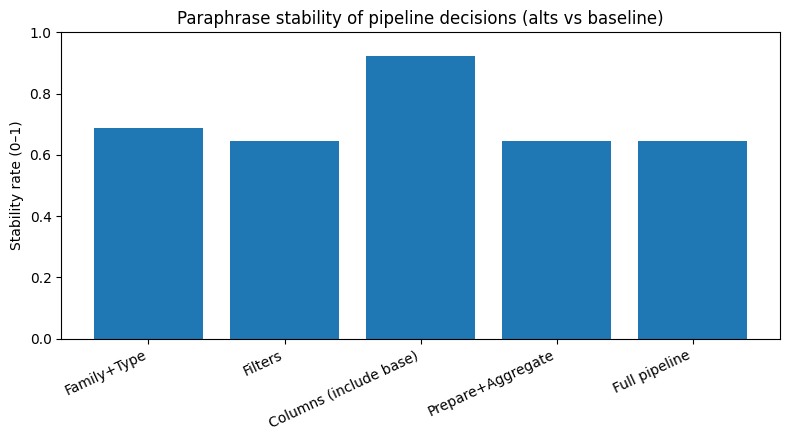

In [108]:
import matplotlib.pyplot as plt

labels = ["Family+Type", "Filters", "Columns (include base)", "Prepare+Aggregate", "Full pipeline"]
values = [
    alts["same_family_type"].mean(),
    alts["same_filters"].mean(),
    alts["columns_include_base"].mean(),
    alts["same_prepare_aggregate"].mean(),
    alts["all_three_ok"].mean(),
]

plt.figure(figsize=(8,4.5))
plt.bar(labels, values)
plt.ylim(0,1)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Stability rate (0–1)")
plt.title("Paraphrase stability of pipeline decisions (alts vs baseline)")
plt.tight_layout()
plt.show()

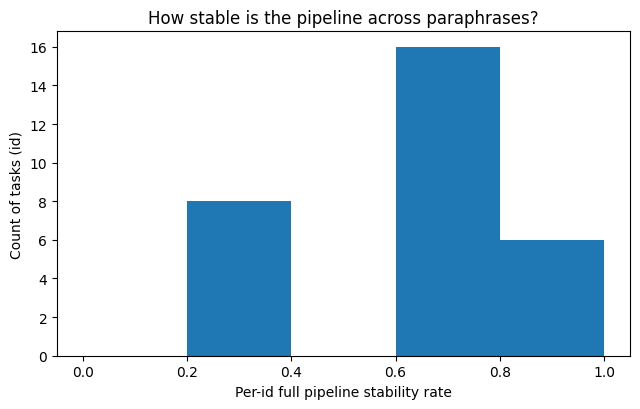

In [109]:
per_id = alts.groupby("id", as_index=False).agg(rate_all=("all_three_ok", "mean"))
plt.figure(figsize=(6.5,4.2))
plt.hist(per_id["rate_all"], bins=np.linspace(0,1,6))
plt.xlabel("Per-id full pipeline stability rate")
plt.ylabel("Count of tasks (id)")
plt.title("How stable is the pipeline across paraphrases?")
plt.tight_layout()
plt.show()